<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Useful-Websites" data-toc-modified-id="Useful-Websites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Useful Websites</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Utility-Functions" data-toc-modified-id="Utility-Functions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Utility Functions</a></span></li><li><span><a href="#UK" data-toc-modified-id="UK-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>UK</a></span><ul class="toc-item"><li><span><a href="#31st-March" data-toc-modified-id="31st-March-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>31st March</a></span></li><li><span><a href="#3rd-April" data-toc-modified-id="3rd-April-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>3rd April</a></span></li></ul></li><li><span><a href="#USA" data-toc-modified-id="USA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>USA</a></span></li><li><span><a href="#China" data-toc-modified-id="China-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>China</a></span></li><li><span><a href="#Italy" data-toc-modified-id="Italy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Italy</a></span><ul class="toc-item"><li><span><a href="#5th-April" data-toc-modified-id="5th-April-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>5th April</a></span></li></ul></li><li><span><a href="#Germany" data-toc-modified-id="Germany-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Germany</a></span></li><li><span><a href="#Singapore" data-toc-modified-id="Singapore-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Singapore</a></span></li><li><span><a href="#Spain" data-toc-modified-id="Spain-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Spain</a></span><ul class="toc-item"><li><span><a href="#4th-April" data-toc-modified-id="4th-April-10.1"><span class="toc-item-num">10.1&nbsp;&nbsp;</span>4th April</a></span></li></ul></li><li><span><a href="#Korea,-South" data-toc-modified-id="Korea,-South-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Korea, South</a></span></li><li><span><a href="#Netherlands" data-toc-modified-id="Netherlands-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Netherlands</a></span></li><li><span><a href="#Ireland" data-toc-modified-id="Ireland-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Ireland</a></span></li><li><span><a href="#Romania" data-toc-modified-id="Romania-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Romania</a></span></li><li><span><a href="#France" data-toc-modified-id="France-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>France</a></span><ul class="toc-item"><li><span><a href="#5th-April" data-toc-modified-id="5th-April-15.1"><span class="toc-item-num">15.1&nbsp;&nbsp;</span>5th April</a></span></li></ul></li><li><span><a href="#Denmark" data-toc-modified-id="Denmark-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Denmark</a></span></li><li><span><a href="#Australia" data-toc-modified-id="Australia-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Australia</a></span></li><li><span><a href="#Sweden" data-toc-modified-id="Sweden-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Sweden</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-19"><span class="toc-item-num">19&nbsp;&nbsp;</span>Comparison</a></span></li></ul></div>

In [222]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Show code..."></form>''')

# Overview
## Useful Websites
World:
* https://www.worldometers.info/coronavirus/#countries

UK specific:
* https://www.arcgis.com/apps/opsdashboard/index.html#/f94c3c90da5b4e9f9a0b19484dd4bb14
* https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#number-of-cases

Excellent comparison graphs, and straightforward, non-click-bait commentary:
* http://nrg.cs.ucl.ac.uk/mjh/covid19/

Country codes:
* https://www.iban.com/country-codes

## EDA
The data is updated daily as a csv file, which makes this analysis fairly easy to get started. Let's check the data for the UK, and explore what the growth looks like.

In [2]:
from urllib.request import urlretrieve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')
sns.set_style('whitegrid')
sns.set_context('talk')
VERBOSE = False

file = 'time_series_19-covid-Confirmed.csv'
old_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
path = '../data/raw/'

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

_ = urlretrieve(url, path+file)

# sanity check data size - changes need to be checked
df = pd.read_csv(path+file)
col_count = pd.Timestamp.now().now() - pd.to_datetime('2020-01-22')
col_count /= pd.Timedelta('1D')
col_count += 4
col_count = np.floor(col_count)

if VERBOSE:
    print(df.shape)
assert df.shape[1] == col_count, 'More columns than expected'
assert df.shape[0] == 263, f'More rows than expected. {df.shape}'

# Set blank province to the country/region name
idx = df['Province/State'].isna()
df.loc[idx, 'Province/State'] = df.loc[idx, 'Country/Region']

tidy_df = df.melt(id_vars=['Province/State', 'Lat', 'Long', 'Country/Region'],
                  value_name='Cases',
                  var_name='Date').reset_index()
tidy_df['Date'] = pd.to_datetime(tidy_df['Date'], format='%m/%d/%y')
tidy_df = tidy_df.set_index('Date').sort_index()
if VERBOSE:
    tidy_df['Country/Region'].value_counts().head(10)


## Utility Functions

In [3]:
def add_today(tidy_df, country, value, province=False):
    """ Add todays number to yesterdays data set """
    idx = []
    # Check we haven't already added
    if province:
        idx = tidy_df['Province/State'] == country
    else:
        idx = tidy_df['Country/Region'] == country
    today_dt = pd.to_datetime(pd.Timestamp.now().date())
    
    if tidy_df[idx][today_dt:].shape[0] == 1:
        # set the value
        idx &= tidy_df.index == today_dt
        if idx.sum() == 0:
            print('Broken')
        tidy_df.loc[idx, 'Cases'] = value
    elif tidy_df[idx][today_dt:].shape[0] == 0:
        today = tidy_df[idx].loc[today_dt - pd.Timedelta('1D'):].copy()
        today.index = [pd.Timestamp(today_dt)]
        today['Cases'] = value
        tidy_df = pd.concat([tidy_df, today], axis=0)
    else:
        raise Exception('Too many matching entries')

    return tidy_df

In [4]:
def loss_function(series, strategy='rmse', debug=False):
    """ Given a Series of residuals, return a loss score """
    series = series.dropna()
    if series.shape[0] == 0:
        score = np.nan
    elif abs(series.sum()) < 0.001:
        print(series)
        raise Exception('Zero residual sum not possible')
    elif strategy == 'mse':
        score = np.sum(series**2)
    elif strategy == 'rmse':
        score = np.sum(series**2)**0.5
    elif strategy == 'best_fit_last':
        # rmse - but with a final multiple which
        # strongly biases more recent residuals
        half = int(round(len(series)/2.0))
        blank = np.zeros(half)
        mult = np.linspace(1, 2, int(len(series)-half))**2
        mult = np.concatenate([blank, mult])
        score = series**2
        score = np.multiply(mult, score)
        score = np.sum(score)**0.5
        if debug:
            print(mult)
    return score

# Test to a given decimal point accuracy
test = pd.Series(np.linspace(0,0.9,10))
dp_acc = 2

assert_results = {'mse': 2.85,
                  'rmse': 1.69,
                  'best_fit_last': 2.67}

for strategy, result in assert_results.items():
    mult = 10**dp_acc
    val = loss_function(test, strategy=strategy)  
    assert round(val*mult) == result*mult, f'{val} does not match {result}'


In [5]:
def sig_pred_case(i, duration=70, peak=80000, spread=16):
    numer = peak
    # exp(0) happens at 50% time of infection
    index = i - duration/2
    # in np.exp(y) - we want y to be between -5 and +5
    # 2020-03-14: in np.exp(y) - we want y to be between -8 and +8
    lam = spread/duration
    denom = (1+np.exp(-1*lam*index))
    sig_num = numer/denom
    return sig_num

# Test
test_peak = 80000
test_dur = 70
assert sig_pred_case(0, test_dur, test_peak, 16)/test_peak < 0.001
assert sig_pred_case(test_dur/2, test_dur, test_peak, 16.0)/test_peak == 0.5
assert sig_pred_case(test_dur-1, test_dur, test_peak, 16.0)/test_peak > 0.999

In [6]:
from sklearn.metrics import r2_score
import matplotlib.dates as mdates

def plot_total_cases(plot_df, plot_dict):
    country = plot_dict['country']
    start_str = plot_dict['start_str']
    best_duration = plot_dict['best_duration']
    best_peak = plot_dict['best_peak']
    r2 = plot_dict['r2']
    
    fig, ax = plt.subplots(1, 1, figsize=(14,10))
    sns.lineplot(data=plot_df,
                 ax=ax,
                 marker='o')

    # set ticks every week
    #ax.get_xaxis().set_major_locator(mdates.WeekdayLocator())
    # set major ticks format
    #ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %d'))

    plt.title(f'{country}\nStart: {start_str}\nDuration: {best_duration:.0f}\nPeak: {best_peak:.0f}\nR-squared: {r2:.3f}')
    plt.tight_layout()
    plt.show()

In [7]:
def plot_daily_cases(plot_df, plot_dict):
    country = plot_dict['country']
    fig, ax = plt.subplots(1, 1, figsize=(14,7))
    
    df = plot_df.diff()
    df.plot(kind='bar', ax=ax)
    
    # set ticks every week
    #ax.get_xaxis().set_major_locator(mdates.WeekdayLocator())
    # set major ticks format
    #ax.get_xaxis().set_major_formatter(mdates.DateFormatter('%b %d'))
    
    plt.title(f'{country}\nEstimated Daily new cases')
    plt.tight_layout()
    plt.show()

In [8]:
def find_best_parameters(df, arg_dict):
    peak_guess = arg_dict['peak_guess']
    duration_guess = arg_dict['duration_guess']
    spread = arg_dict['spread']
    strategy = arg_dict['strategy']
    start_str = arg_dict['start_str']
    # grid search best RMSE
    score_df = pd.DataFrame({'peak':[], 'duration':[], 'score':[]}).set_index(['peak', 'duration'])

    peak_grid = range(round(0.5*peak_guess),
                      round(1.5*peak_guess),
                      round(0.025*peak_guess))
    
    duration_grid = range(duration_guess-4,
                          duration_guess+3,
                          1)
    for peak in peak_grid:
        for duration in duration_grid:
            sig_case_lst = []
            for i in range(0, duration):
                sig_case_lst.append(sig_pred_case(i, duration, peak, spread=spread))

            current_df = pd.DataFrame(sig_case_lst,
                                      index=pd.date_range(start_str,
                                                          periods=duration))

            conc_df = pd.concat([df[start_str:], current_df], axis=1)
            conc_df.columns = ['Actual', 'Prediction']
            conc_df['residual'] = conc_df['Actual'] - conc_df['Prediction']
            score_df.loc[(peak, duration), 'score'] = loss_function(conc_df['residual'],
                                                                    strategy=strategy)
    
    best_peak, best_duration = score_df['score'].argmin()
    best_score = score_df.loc[(best_peak, best_duration), 'score']
    return best_peak, best_duration, best_score

In [9]:
def plot_country(all_df,
                 country='United Kingdom',
                 start_str='2020-02-26',
                 peak_guess=120000,
                 duration_guess=79,
                 strategy='rmse',
                 offset=None,
                 spread=16.0,
                 province=False):

    if offset:
        pass
    else:
        offset=round(duration_guess/8)
    
    arg_dict = {'country': country,
                'start_str': start_str,
                'strategy': strategy,
                'offset': offset,
                'spread': spread,
                'peak_guess': peak_guess,
                'duration_guess': duration_guess}
    
    actual_df = pd.DataFrame()
    pred_df = pd.DataFrame()
    conc_df = pd.DataFrame()
    idx = [False]
    if province:
        idx = all_df['Province/State'] == country
    else:
        idx = all_df['Country/Region'] == country
    
    actual_df = all_df.loc[idx, 'Cases'].resample('D').sum()

    best_peak, best_duration, best_score = find_best_parameters(actual_df, arg_dict)

    duration = int(best_duration)
    peak = int(best_peak)

    pred_lst = []
    for i in range(0, duration):
        pred_lst.append(sig_pred_case(i, duration, peak))


    pred_df = pd.DataFrame(pred_lst,
                           index=pd.date_range(start_str,
                                               periods=duration))

    conc_df = pd.concat([actual_df[start_str:], pred_df], axis=1)
    conc_df.columns = [ 'Actual', 'Prediction']
    conc_df['residual'] = conc_df['Actual'] - conc_df['Prediction']
    y = conc_df.dropna()['Actual']
    y_pred = conc_df.dropna()['Prediction']
    r2 = r2_score(y, y_pred)
    
    arg_dict['best_duration'] = best_duration
    arg_dict['best_peak'] = best_peak
    arg_dict['r2'] = r2

    now_dt = pd.Timestamp.now().date()
    plot_offset = pd.Timedelta(f'{offset}D')
    plot_cols = ['Actual', 'Prediction']
    plot_df = conc_df.loc[now_dt-plot_offset:now_dt+(plot_offset*2), plot_cols]
    
    plot_total_cases(plot_df, arg_dict)
    plot_daily_cases(plot_df, arg_dict)

    return conc_df


## UK
### 31st March
The total tests could be close to, or exceeding the current capacity to propose each day. We had 7k total tests performed today, with 33% shown as positive. A week ago we performed 3k tests (well under the initially capacity) and this showed 12% positive test rate. I would expect that ratio to stay fairly constant unless:
- Hospitals are being more specific with symptoms and testing a smaller set, and this is the real case.
- Hospitals are still testing everybody, but the processing can't keep up at the moment, and the real cases are higher, and will show as bigger peaks in later days.

I tend towards the later explanation, so I'm going to keep the model stats close to Italy for now.

### 3rd April
I suspect the testing is now catching up. I've returned the duration guess to 7*12 days, my initial duration for Italy. I know this is the most optimistic case, but I've seen other countries in Europe; Spain, France and possibly Germany, all show durations less than the current Italian spread. As always this only remains true if people behave in a way the suppresses the spread. It should be clear by the end of next week if we've passed peak new daily cases.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


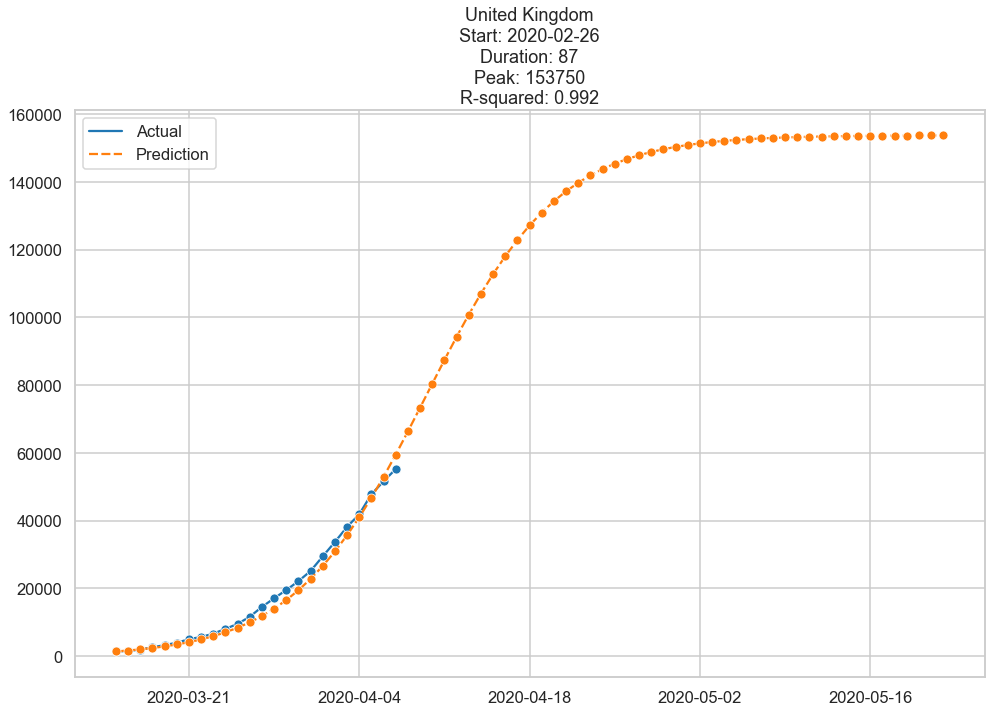

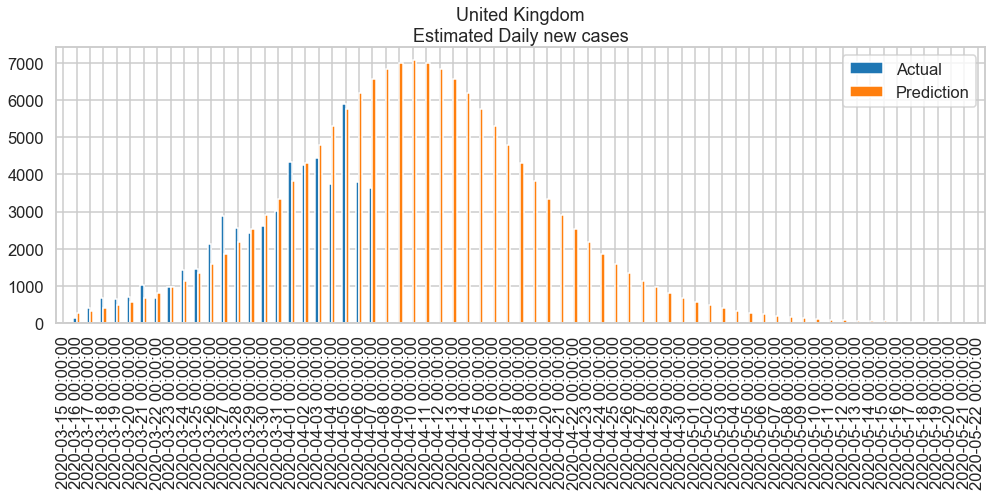

In [16]:
country = 'United Kingdom'
region = np.nan
start_str = '2020-02-26'
peak_guess = 150000
duration_guess = (7*13)
province=True

corrections = {'2020-03-12': 590,
               '2020-03-15': 1391,
               '2020-03-19': 3269,
               '2020-03-27': 14543,
               '2020-03-28': 17089,
               '2020-04-29': 19522,
               '2020-03-30': 22141,
               '2020-03-31': 25150,
               '2020-04-01': 29474,
               '2020-04-02': 33718,
               '2020-04-03': 38168,
               '2020-04-04': 41903,
               '2020-04-05': 47806,
               '2020-04-06': 51608,
               }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df['Province/State'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 55242, province=province)

gb_df = plot_country(tidy_df,
                     country=country, 
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     strategy='best_fit_last',
                     offset=round(duration_guess/4),
                     province=province,
                    )

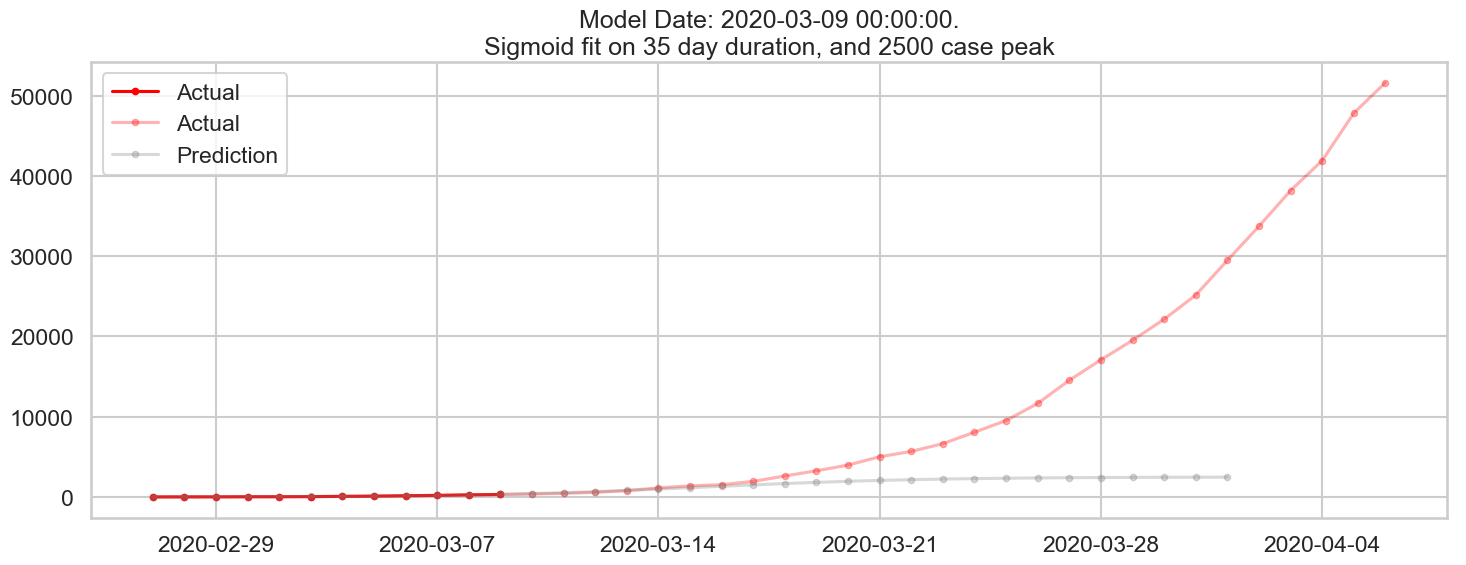

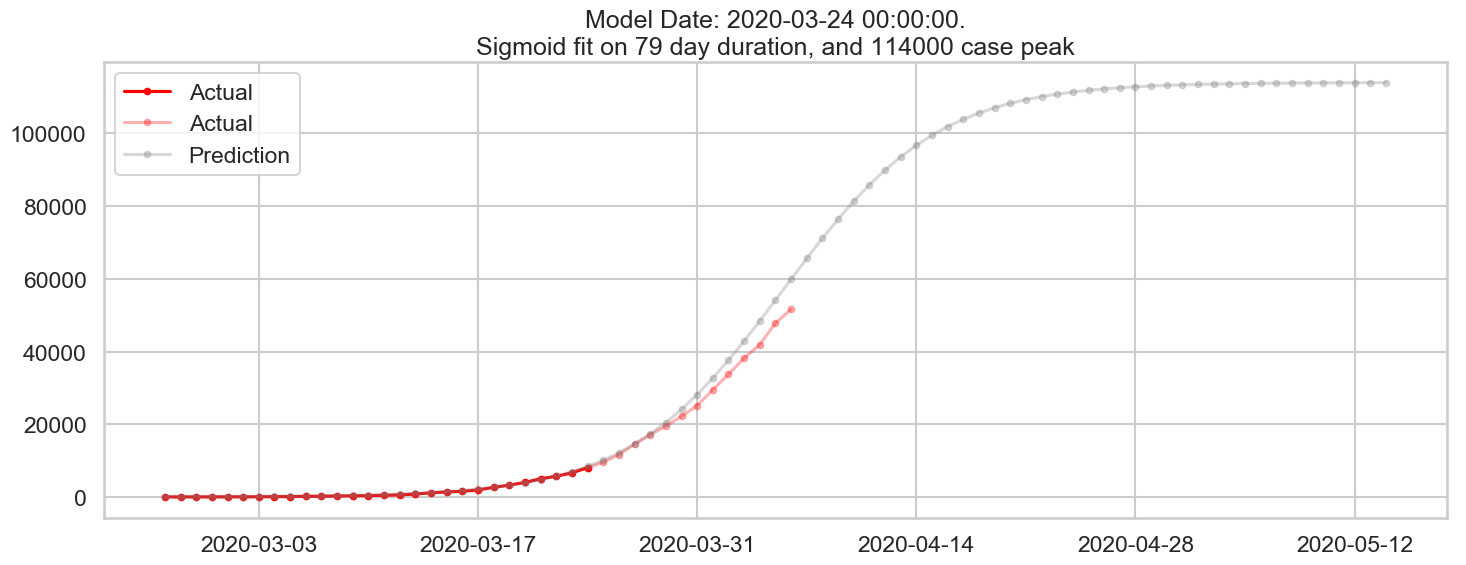

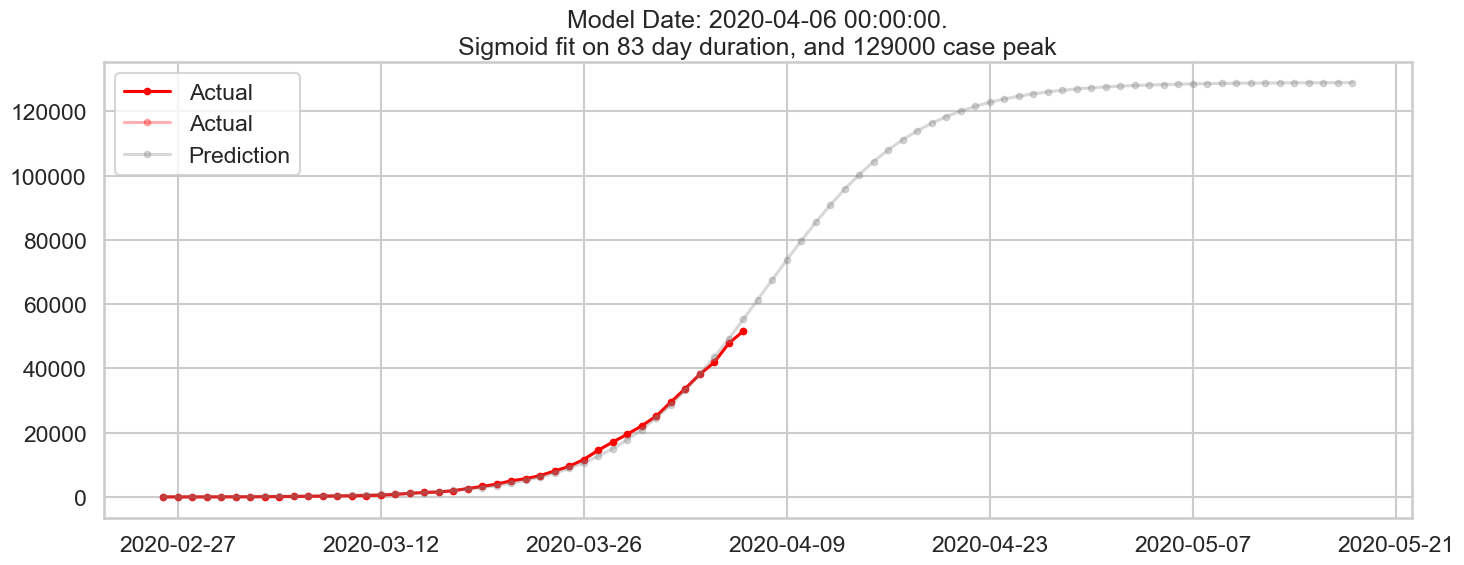

In [489]:
# Track model guess over time
best_fit_df = pd.DataFrame({'date': [pd.to_datetime('2020-03-09'),
                                     pd.to_datetime('2020-03-10'),
                                     pd.to_datetime('2020-03-11'),
                                     pd.to_datetime('2020-03-12'),
                                     pd.to_datetime('2020-03-13'),
                                     pd.to_datetime('2020-03-14'),
                                     pd.to_datetime('2020-03-15'),
                                     pd.to_datetime('2020-03-21'),
                                     pd.to_datetime('2020-03-22'),
                                     pd.to_datetime('2020-03-23'),
                                     pd.to_datetime('2020-03-24'),
                                     pd.to_datetime('2020-03-26'),
                                     pd.to_datetime('2020-03-28'),
                                     pd.to_datetime('2020-03-29'),
                                     pd.to_datetime('2020-03-30'),
                                     pd.to_datetime('2020-03-31'),
                                     pd.to_datetime('2020-04-03'),
                                     pd.to_datetime('2020-04-05'),
                                     pd.to_datetime('2020-04-06'),
                                    ],
                            'start': ['2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                     ],
                            'spread': [10,
                                       10,
                                       10,
                                       10,
                                       10,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                      ],
                            'duration': [35,
                                         42,
                                         41,
                                         38,
                                         40,
                                         64,
                                         62,
                                         79,
                                         79,
                                         79,
                                         79,
                                         80,
                                         81,
                                         84,
                                         80,
                                         84,
                                         80,
                                         83,
                                         83,
                                        ],
                            'peak': [2500,
                                     3800,
                                     3500,
                                     2850,
                                     3350,
                                     59500,
                                     69000,
                                     120000,
                                     115000,
                                     112000,
                                     114000,
                                     117000,
                                     129000,
                                     154000,
                                     118000,
                                     147000,
                                     112500,
                                     129000,
                                     129000,
                                    ]}).set_index('date')


for date in best_fit_df.iloc[[0,round(len(best_fit_df)/2),-1]].index:
    sig_case_lst = []
    duration = best_fit_df.loc[date, 'duration']
    peak = best_fit_df.loc[date, 'peak']
    spread = best_fit_df.loc[date, 'spread']
    start = best_fit_df.loc[date, 'start']
    for i in range(0, duration):
        sig_case_lst.append(sig_pred_case(i, duration=duration, peak=peak, spread=spread))
    pred_df = pd.DataFrame({'Prediction': sig_case_lst}, index=pd.date_range(start, periods=duration))

    fig, ax = plt.subplots(1,1,figsize=(15,6))
    plt.plot(gb_df.loc[start:date, 'Actual'], marker='.', color='red')
    plt.plot(gb_df.loc[date:, 'Actual'], marker='.', color='red', alpha=0.3)
    plt.plot(pred_df['Prediction'], marker='.', color='grey', alpha=0.3)
    plt.legend()
    plt.title(f'Model Date: {date}.\nSigmoid fit on {duration} day duration, and {peak} case peak')
    plt.tight_layout()
    plt.show()


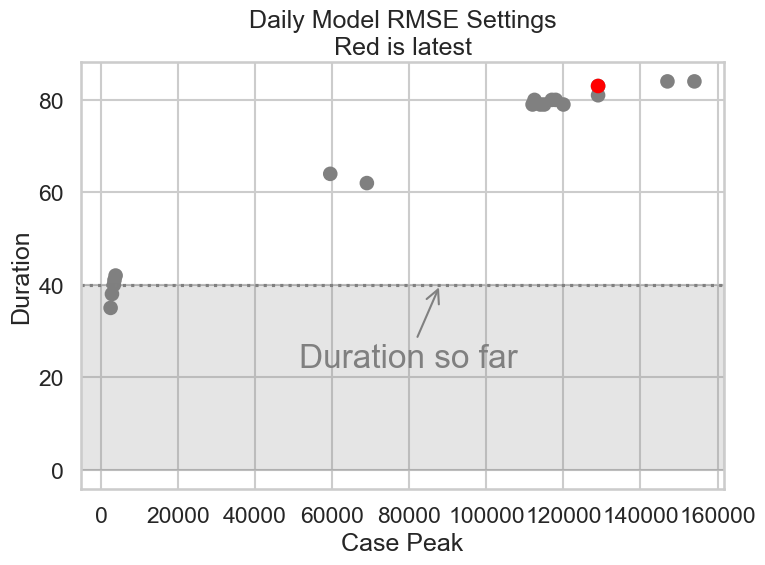

In [490]:
dur_so_far = pd.Timestamp.now() - gb_df.index.min()
dur_so_far /= pd.Timedelta('1D')
dur_so_far = np.floor(dur_so_far)

color_lst = ['gray'] * int(len(best_fit_df) - 1)
color_lst.append('red')

fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.scatter(x=best_fit_df['peak'],
            y=best_fit_df['duration'],
            c=color_lst)
text_color = 'grey'
plt.axhspan(ymin=0, ymax=dur_so_far, color='tab:grey', alpha=0.2)
plt.axhline(dur_so_far, color=text_color, linestyle=':')
plt.annotate(s='Duration so far',
             xy=(best_fit_df['peak'].max()/1.75, dur_so_far),
             arrowprops={'arrowstyle': '->',
                         'color': text_color},
             xytext=(best_fit_df['peak'].max()/3, dur_so_far/1.8),
             color=text_color,
             fontsize=24)
plt.title('Daily Model RMSE Settings\nRed is latest')
plt.xlabel('Case Peak')
plt.ylabel('Duration')
plt.tight_layout()
plt.show()

## USA

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


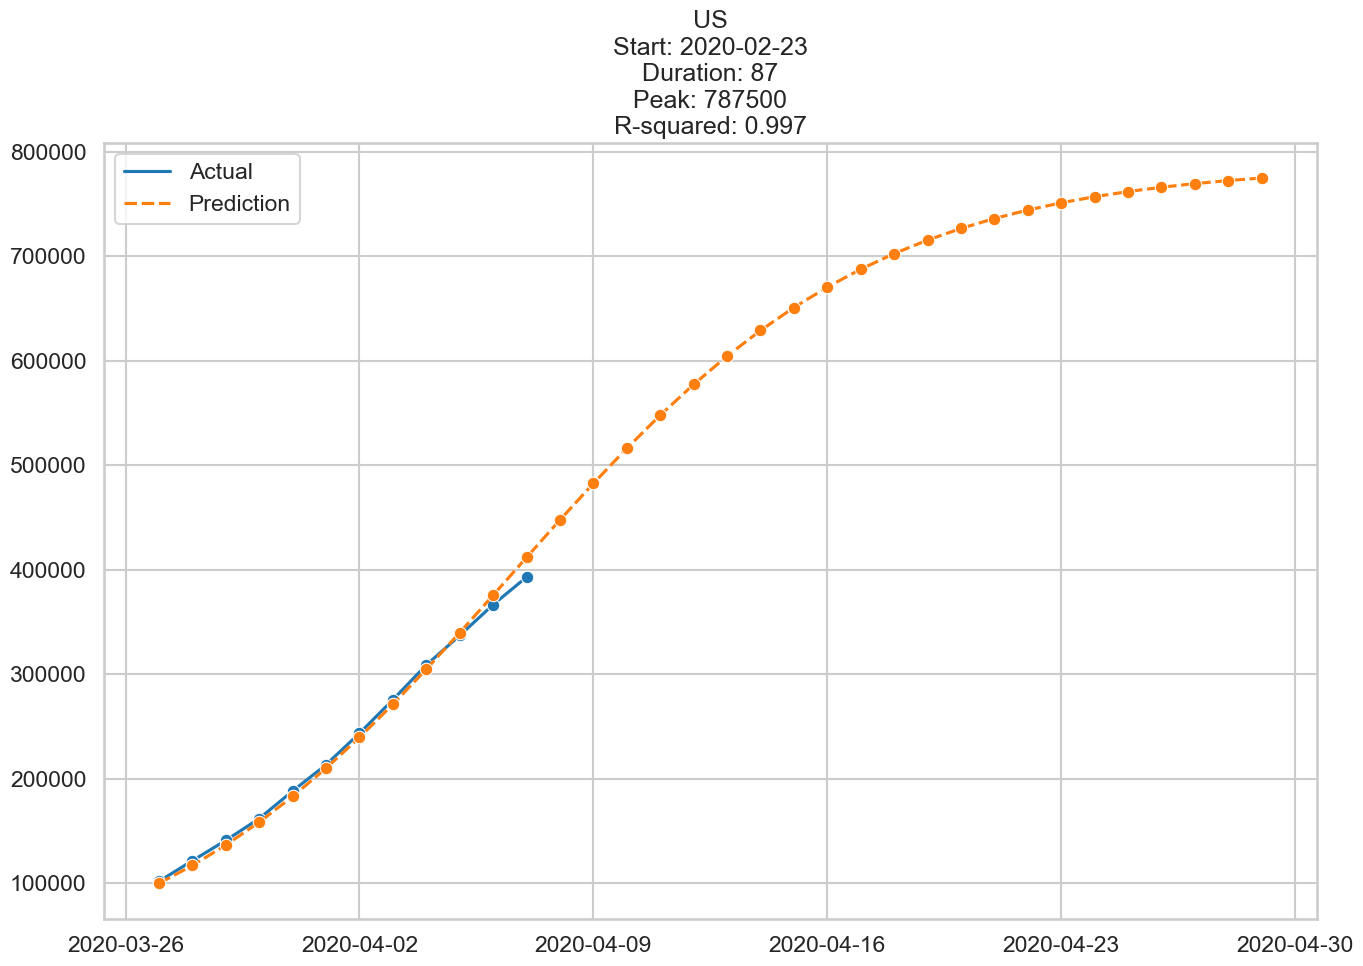

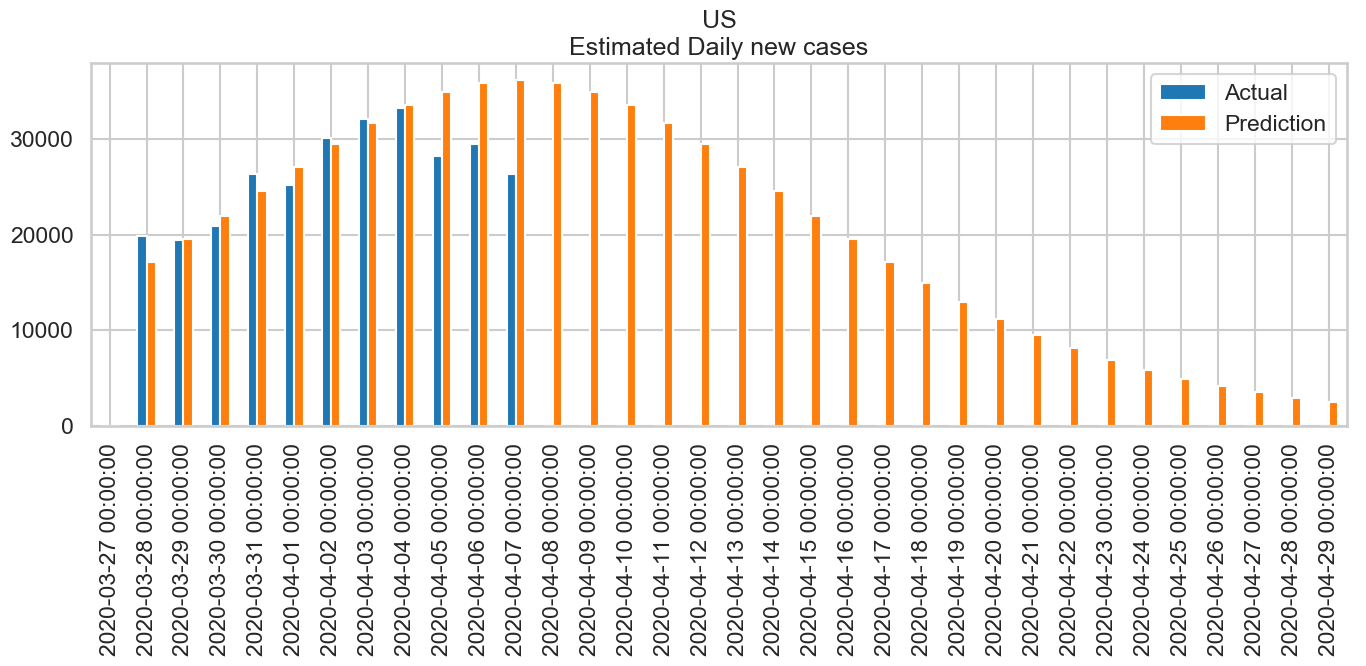

In [504]:
country = 'US'
province = False
#start_str = '2020-02-28'
start_str = '2020-02-23' 
peak_guess = 700000
duration_guess = 7*13

tidy_df = add_today(tidy_df, country, 393000)

us_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     strategy='rmse')

## China

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


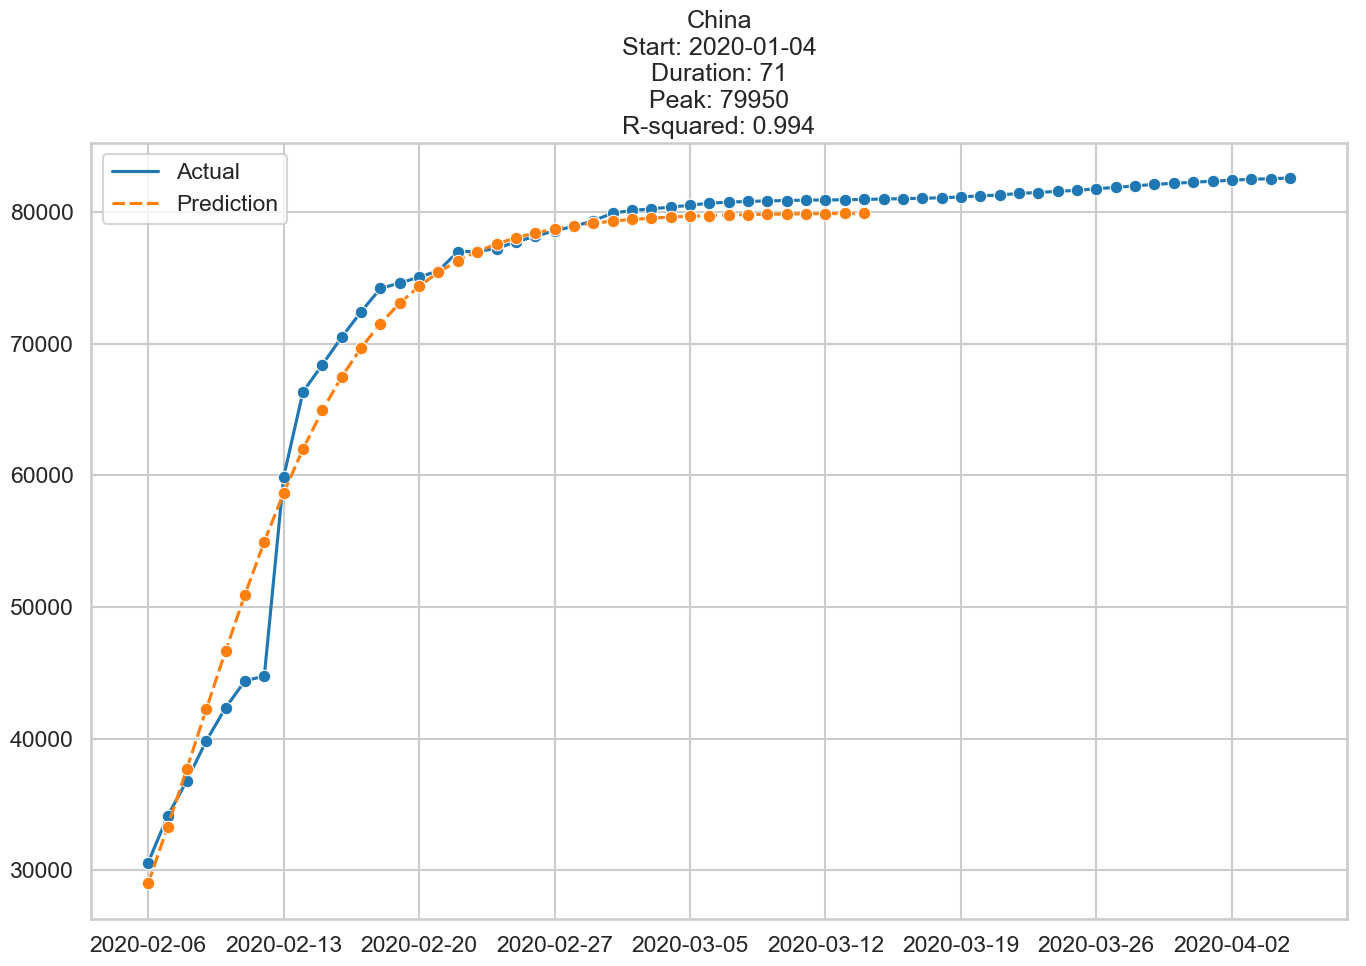

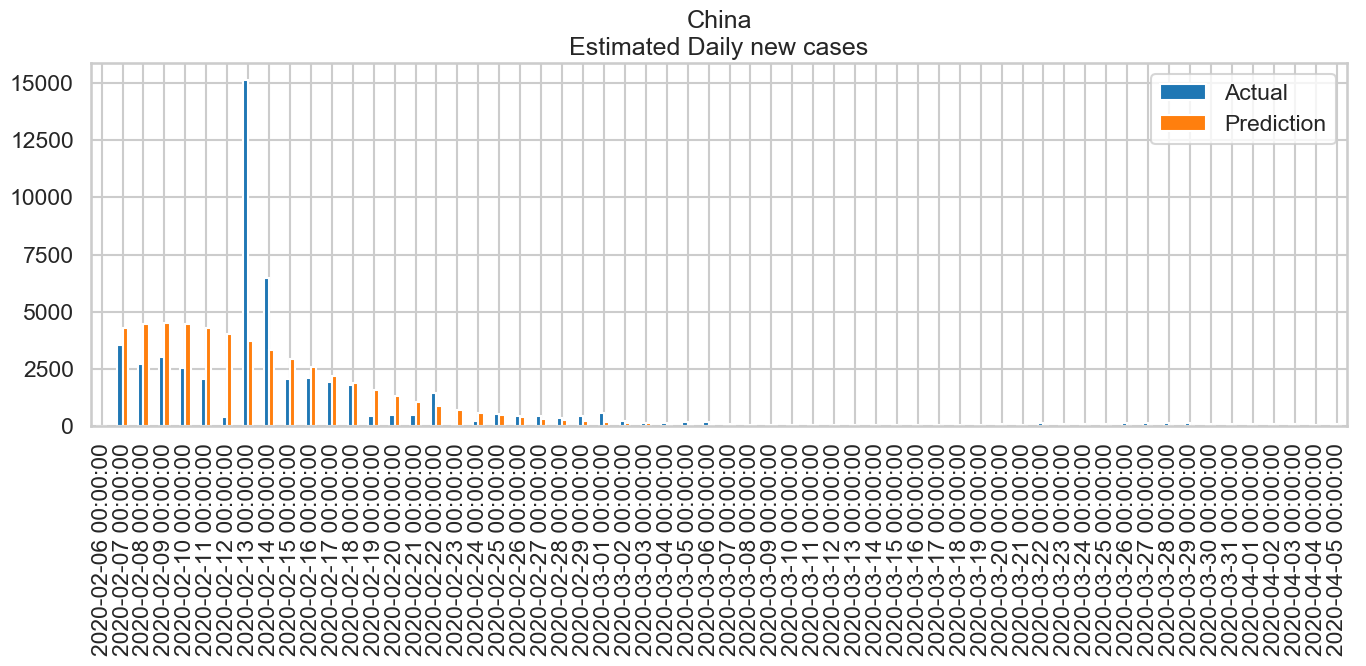

In [497]:
country = 'China'
province = True
start_str = '2020-01-04'
peak_guess = 82000
duration_guess = 72

#tidy_df = add_today(tidy_df, 'Hubei', 81669, province=province)

cn_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     strategy='rmse',
                     offset=60,
                     #province=province,
                    )

## Italy
Italy shares a lot in common with the UK - the same population, the same area, and similar population densities. The most interesting thing about Italy statistically, is I can only fit the middle of the curve, if we I start much earlier than other countries.

With other countries, I set the start as the day that begins day on day case increases. In Italy's case, this is 9 days before that. Perhaps there was a change in testing strategy? Or some time where the virus spread without measurement?

As of 30th March, they are nearly a week beyond their peak daily cases. Deaths lag, so are likely to keep increasing for a period of time. Their duration should set the benchmark for other countries, especially in Europe - however, even at this early stage some countries appear to be quicker (Spain), or much slower (Sweden). It will be interesting to see how that pattern develops, and whether those countries all revert back to the Italian duration.

### 5th April
Italy might be better fit with a skew in the daily case distribution. I can make a case that the lockdown takes a while to change the rate of change, and that manifests as a much steeper climb and a gradual descent. The gradual descent is actually pretty painful, as it starts at the peak, but reduces at a slower speed, increasing the total cases over the duration quite a lot.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


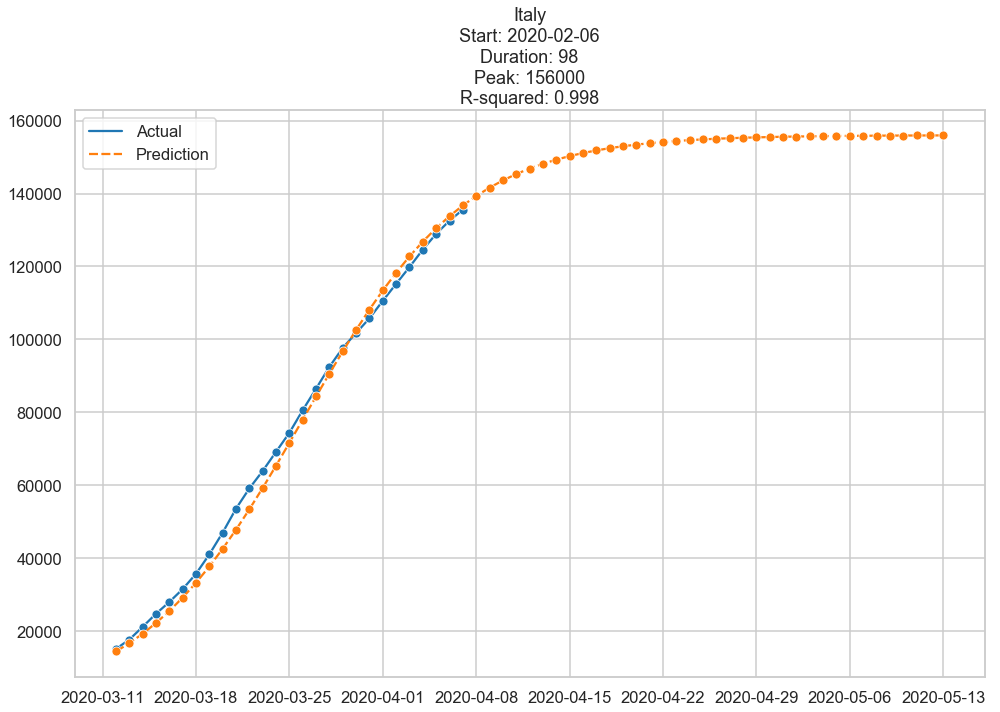

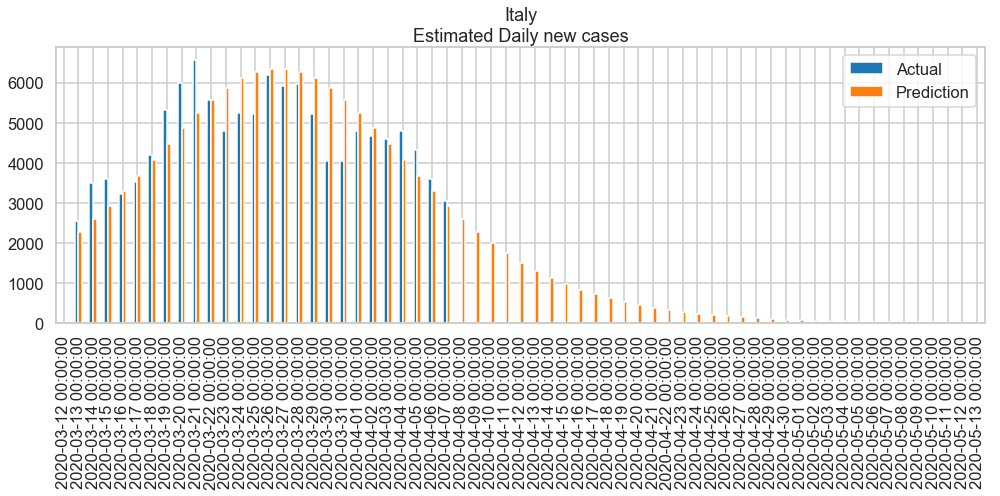

In [17]:
country = 'Italy'
#start_str = '2020-02-10'
start_str = '2020-02-06'
peak_guess = 160000
duration_guess = (7*14)+4

# fix data errors
corrections = {'2020-03-12': 15113,
               '2020-03-23': 63927,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 135586)

it_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     offset=round(duration_guess/4),
                     strategy='rmse')

## Germany
Germany performs a very high percentage of testing. So their total confirmed cases are much closer to the likely figure in their population. The UK only test cases that need hospital care.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


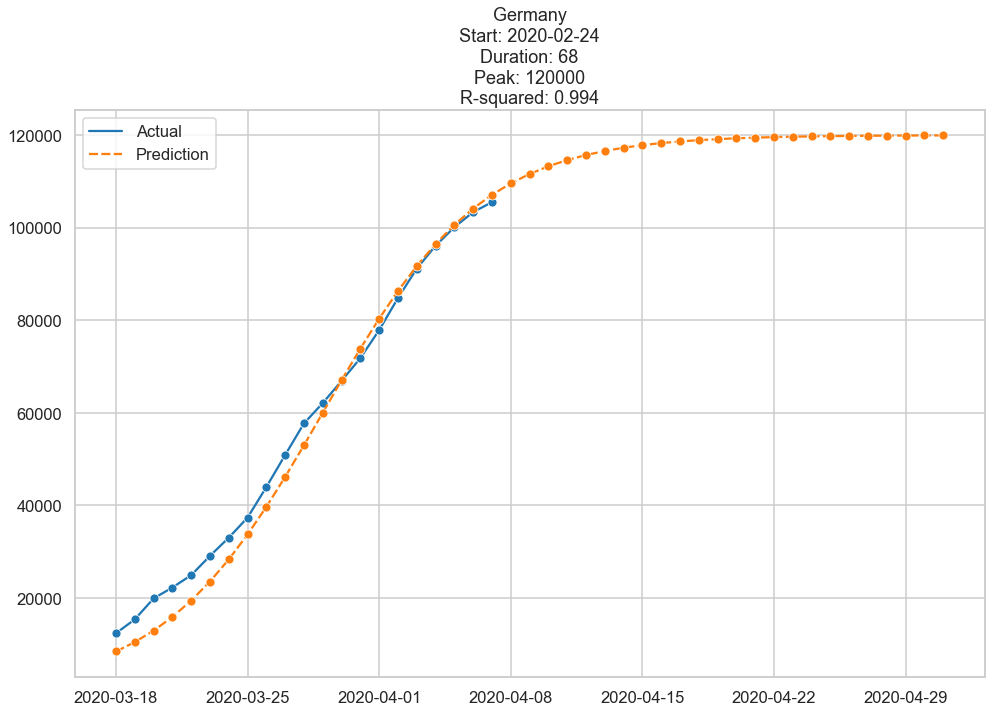

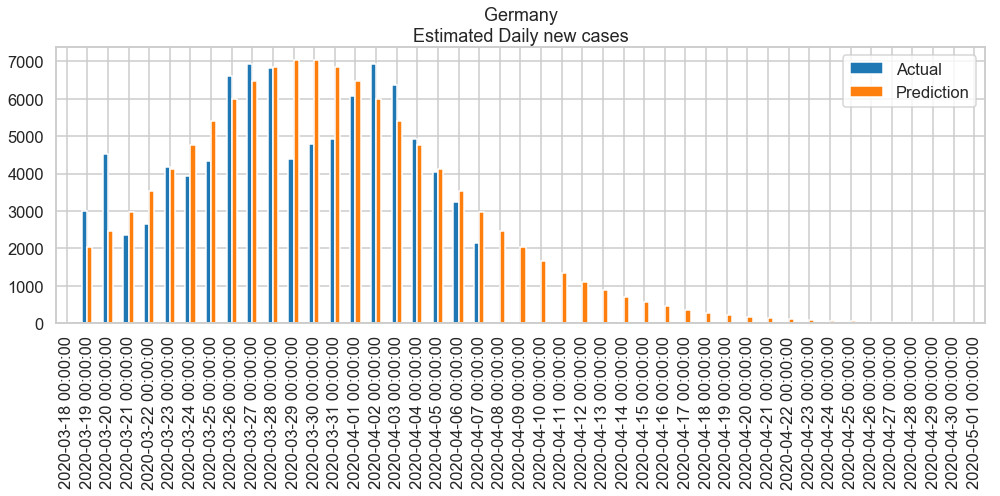

In [24]:
country = 'Germany'
start_str = '2020-02-24'
peak_guess = 150000
duration_guess = (7*10)+2

# fix data errors
corrections = {'2020-03-12': 2745,
               '2020-03-23': 29056,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 105519)

de_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     offset=20, strategy='rmse')

## Singapore
Singapore is incredible - it's both very low and very long. They dealt with SARS before, and yet they have dense population density.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


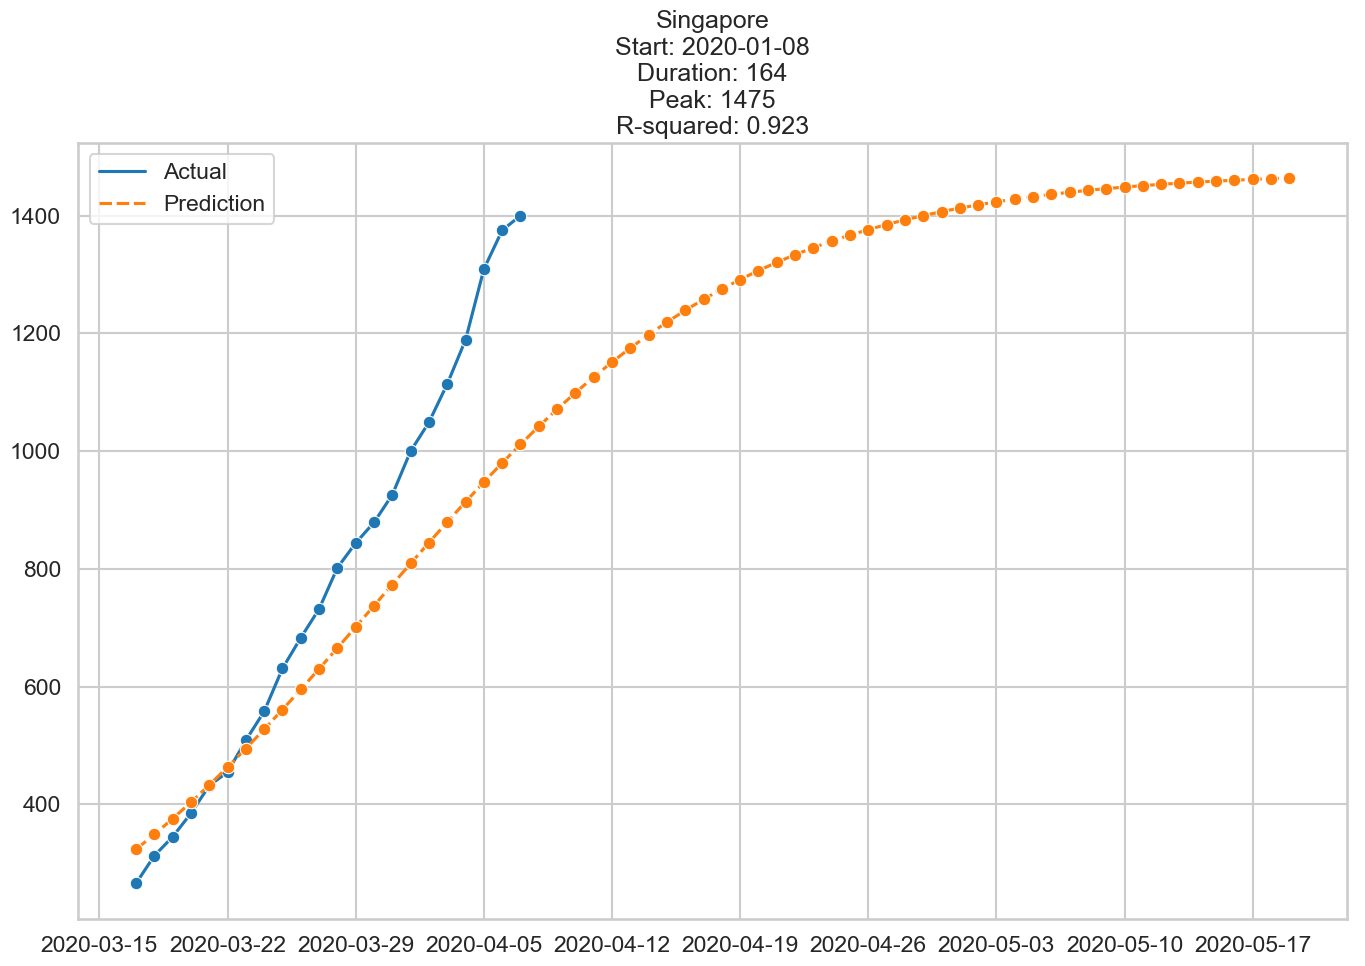

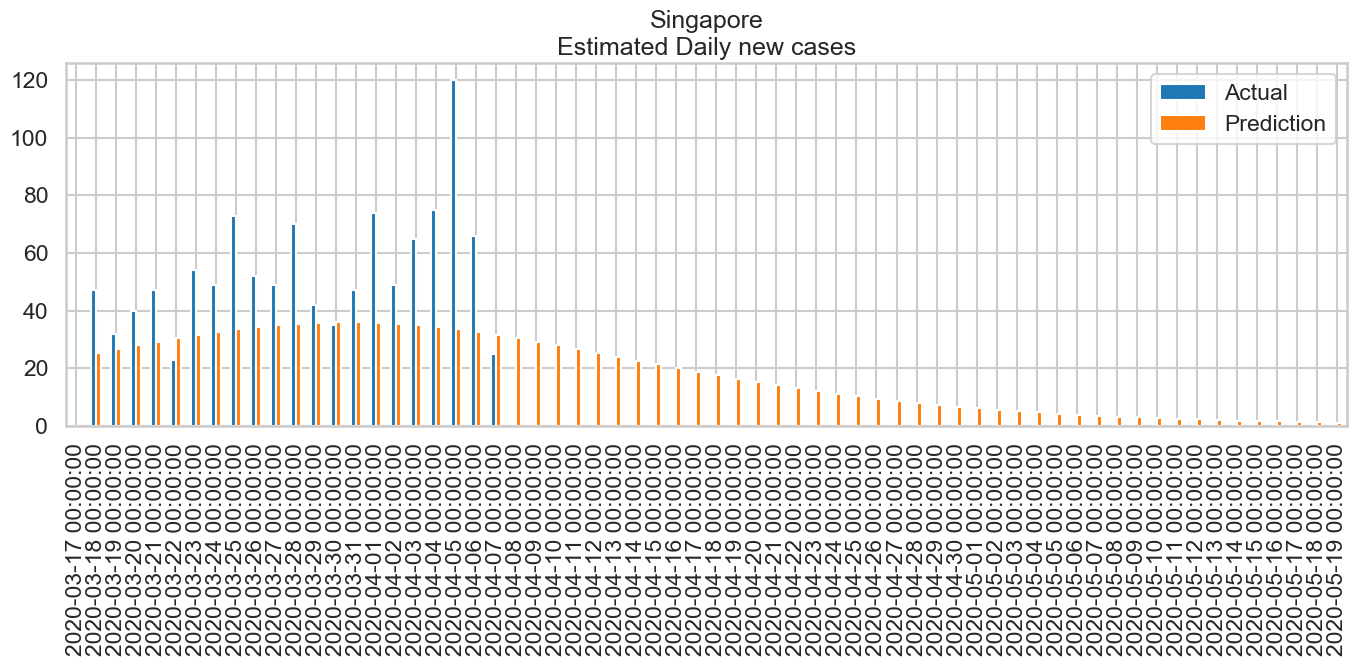

In [539]:
country = 'Singapore'
start_str = '2020-01-08'
peak_guess = 1000
duration_guess = 7*24

# fix data errors
corrections = {'2020-03-23': 509,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 1400)

sn_df = plot_country(tidy_df, country, start_str, peak_guess, duration_guess,
                     strategy='rmse')

## Spain
Spain appears to have the worst out break in Europe, especially when you adjust cases per capita. I need to find their testing per capita to see if they are closer to Germany, who test the most, or the UK, who (until 29th March) just tested hospital admissions with COVID symptoms.

As of 30th March, its possible the Spain curve is starting to dip - I can't tell if this will then rest on a longer, shallower curve: I have seen that pattern on other countries. Or they might have a quicker spread than Italy, by 2 weeks, and they have passed this first peak.

I have modeled the shorter duration for now - the next 4 days should make it clear which curve fits best.

### 4th April
The shorter duration is still fitting quite well. I'm pretty sure Spain has passed the peak. At the same point in time with Italy, I found the duration still increased, but it only moved the peak day 3 days later. Even if that is the case, Spain is almost 3 weeks shorter in duration than Italy. It will be interesting in the analysis that follows to understand why.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


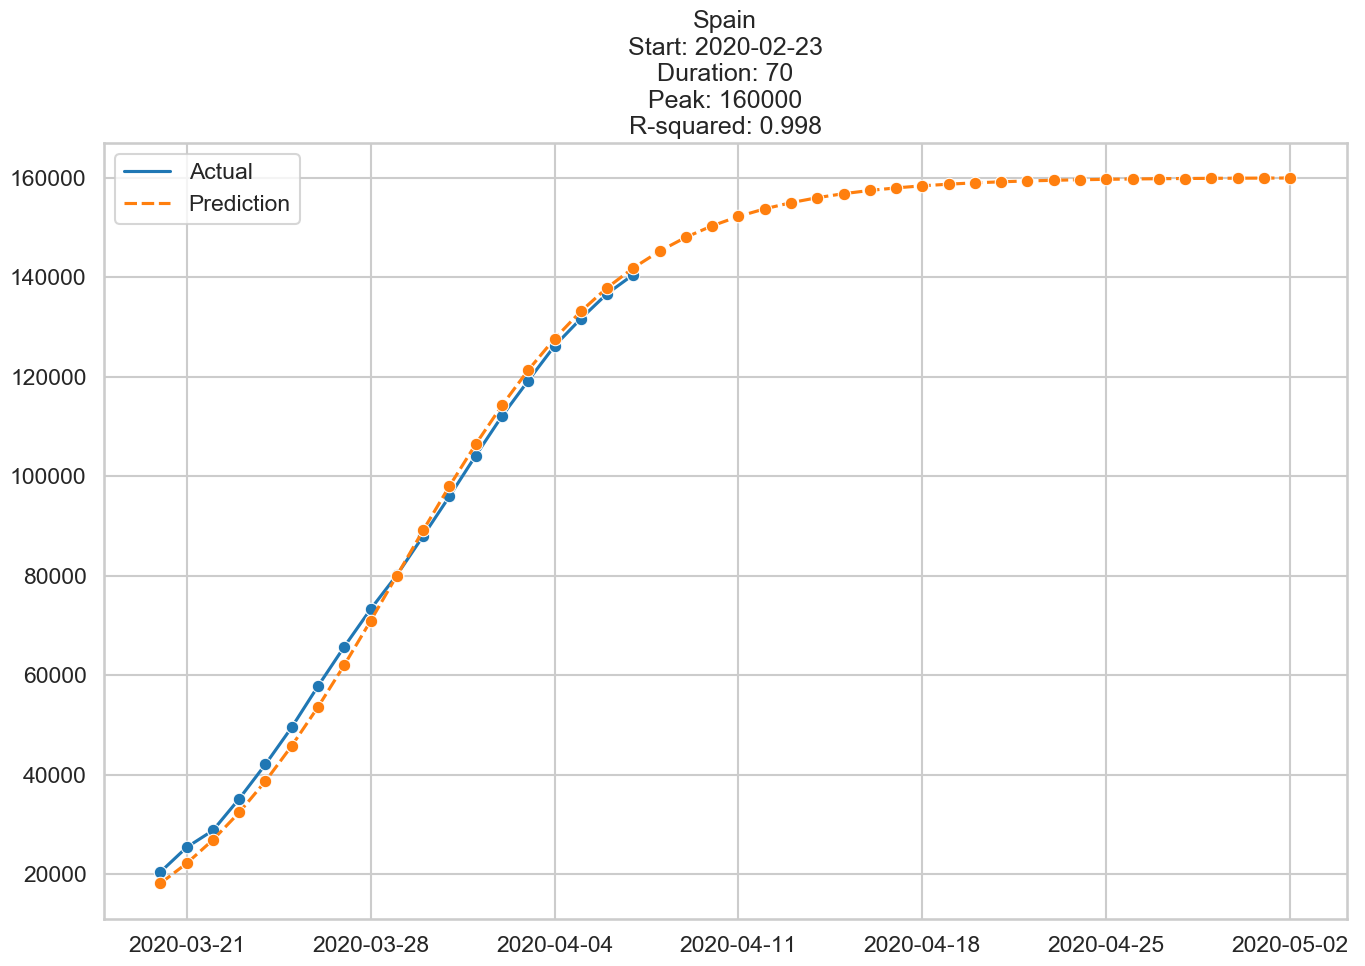

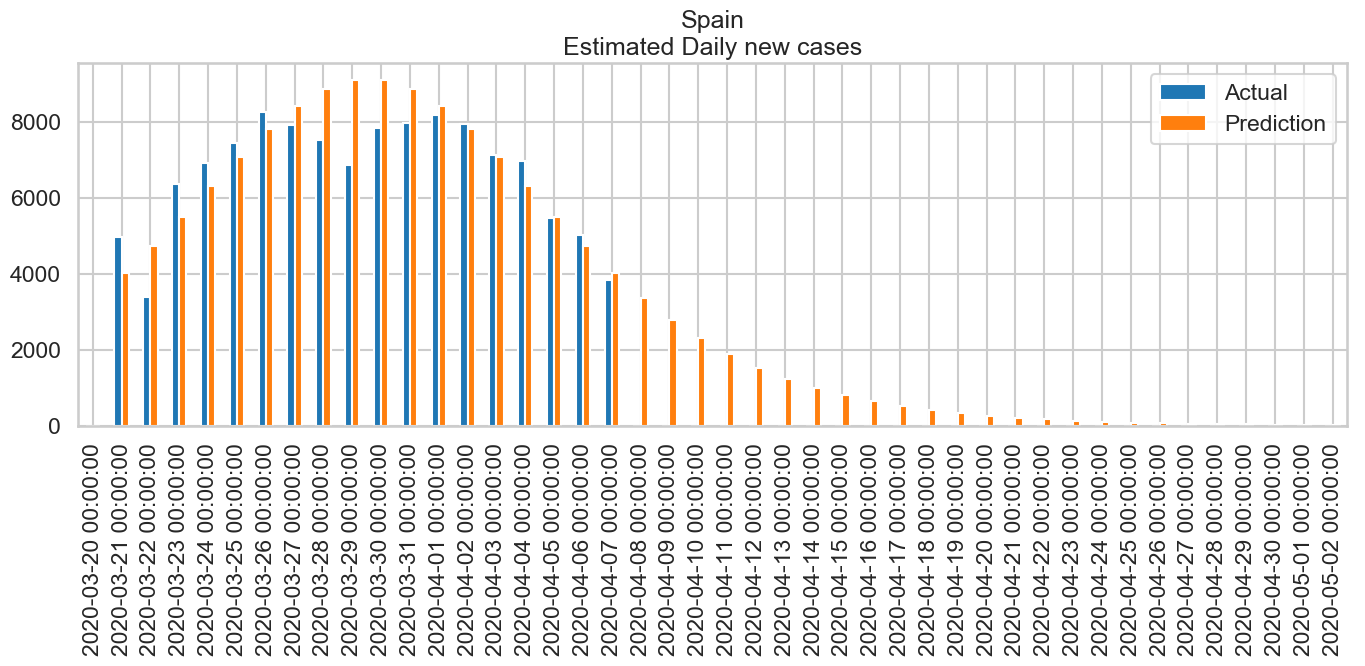

In [528]:
country = 'Spain'
start_str = '2020-02-23'
peak_guess = 160000
duration_guess = (7*10)+4

# fix data errors
corrections = {'2020-03-24': 42058,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 140510)

es_df = plot_country(tidy_df, 
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     spread=16,
                     offset=duration_guess/4,
                     strategy='rmse')

## Korea, South

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


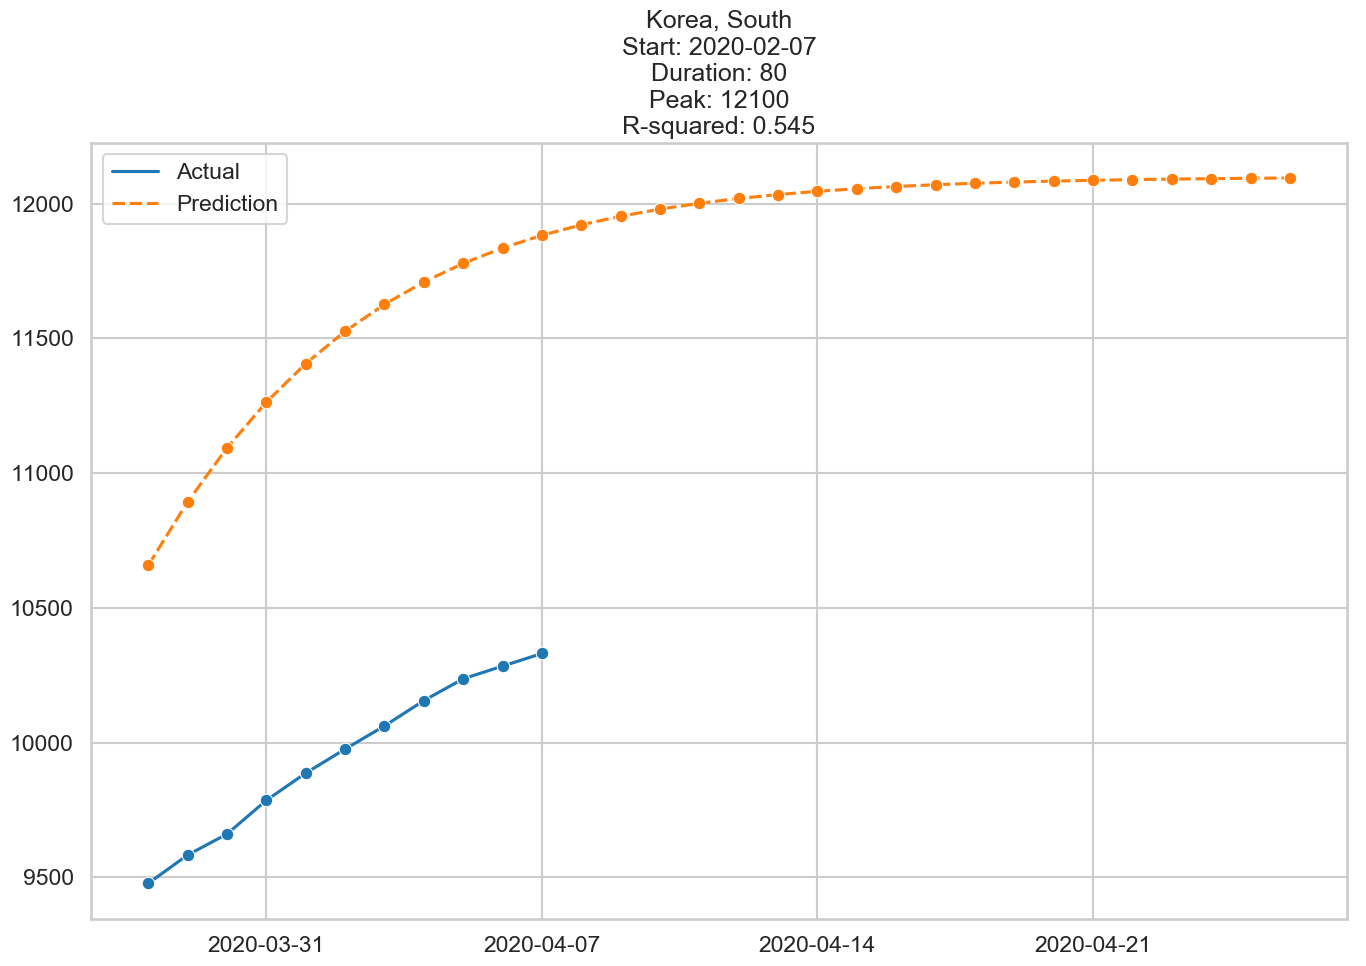

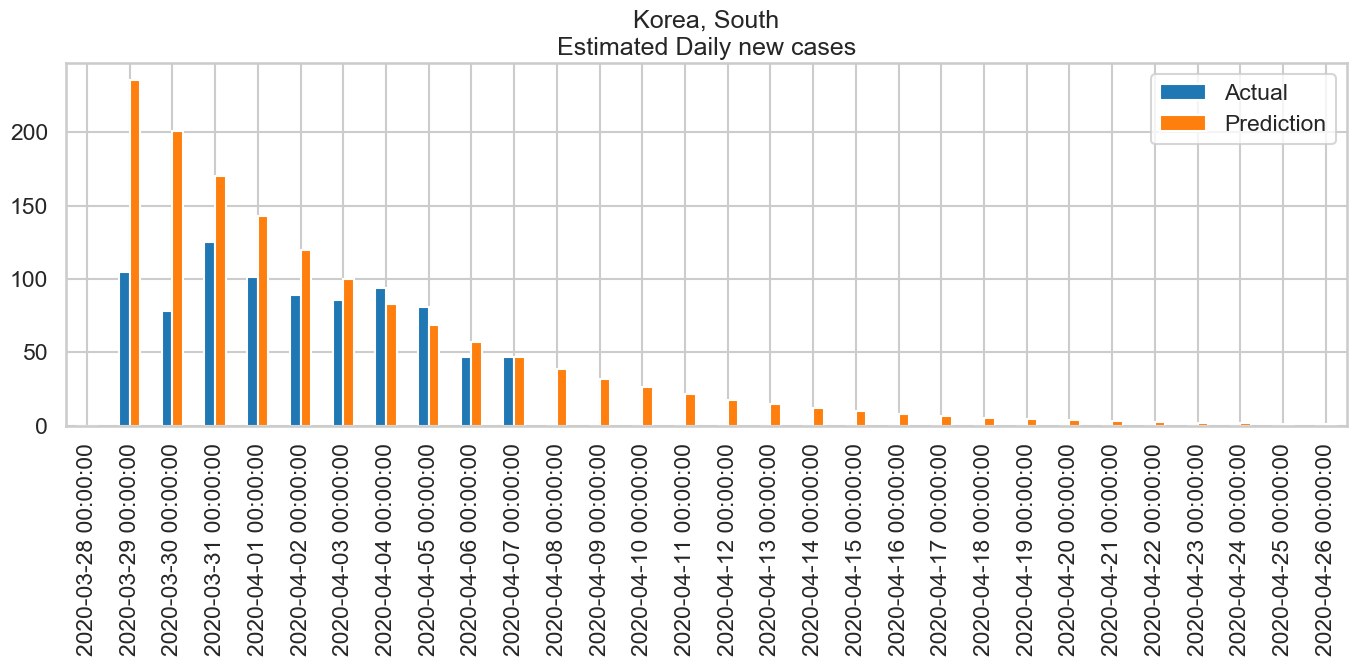

In [512]:
country = 'Korea, South'
start_str = '2020-02-07'
peak_guess = 11000
duration_guess = 7*12

# fix data errors
corrections = {'2020-03-22': 8897,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 10331)

ks_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     )

## Netherlands
31st March - Netherlands need an extra week adding to the duration, compared to Italy, to get a better fit. It's going to take 5 days to get a better feel for the better curves.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


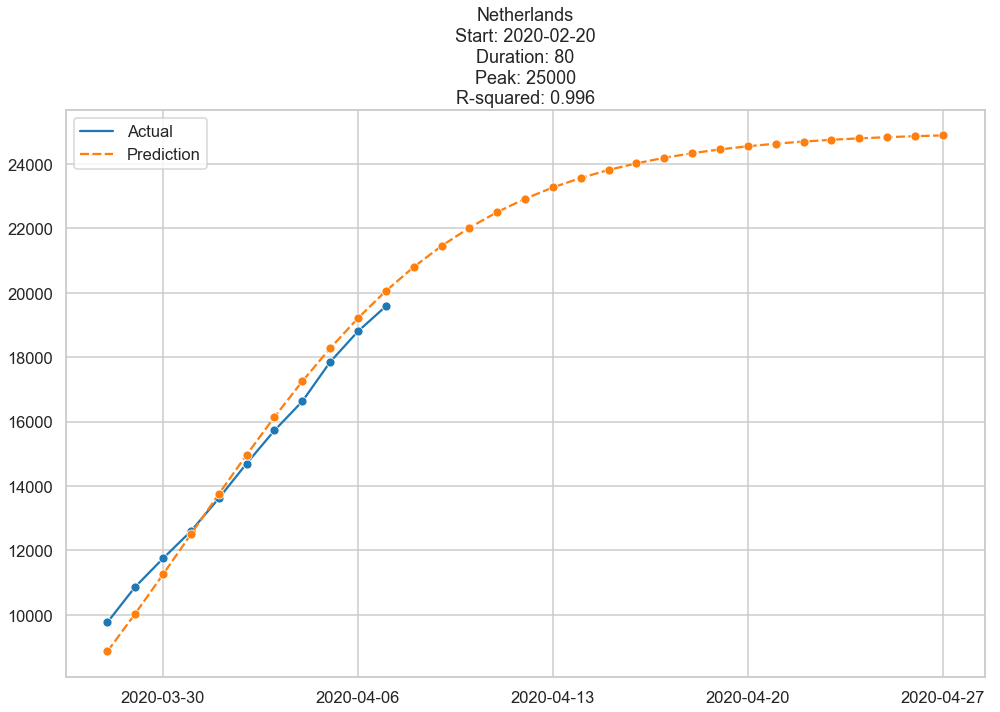

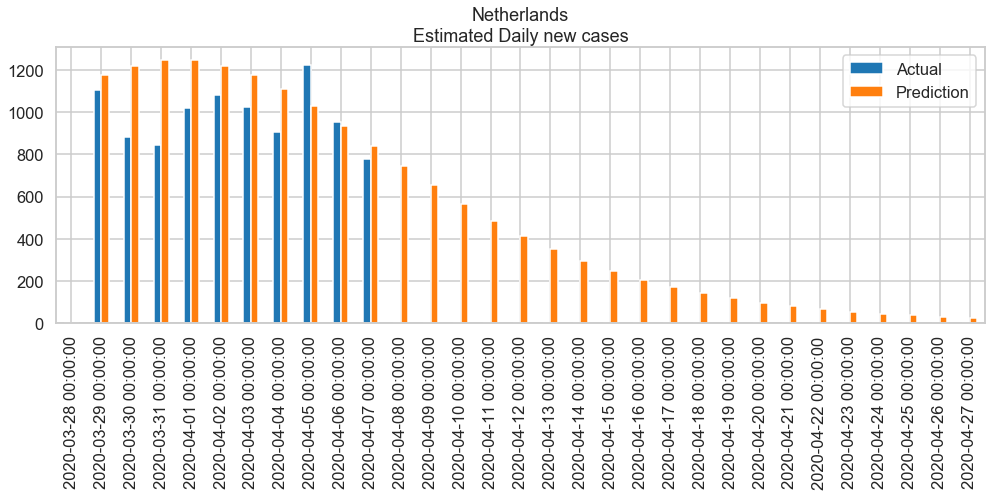

In [25]:
country = 'Netherlands'
province = True
#start_str = '2020-02-27'
start_str = '2020-02-20'
peak_guess = 20000
duration_guess = (7*12)

# fix data errors
corrections = {'2020-03-23': 4749,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df['Province/State'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 19580, province=province)

nd_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str, 
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     province=province,
                     #offset=20
                     )

## Ireland

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


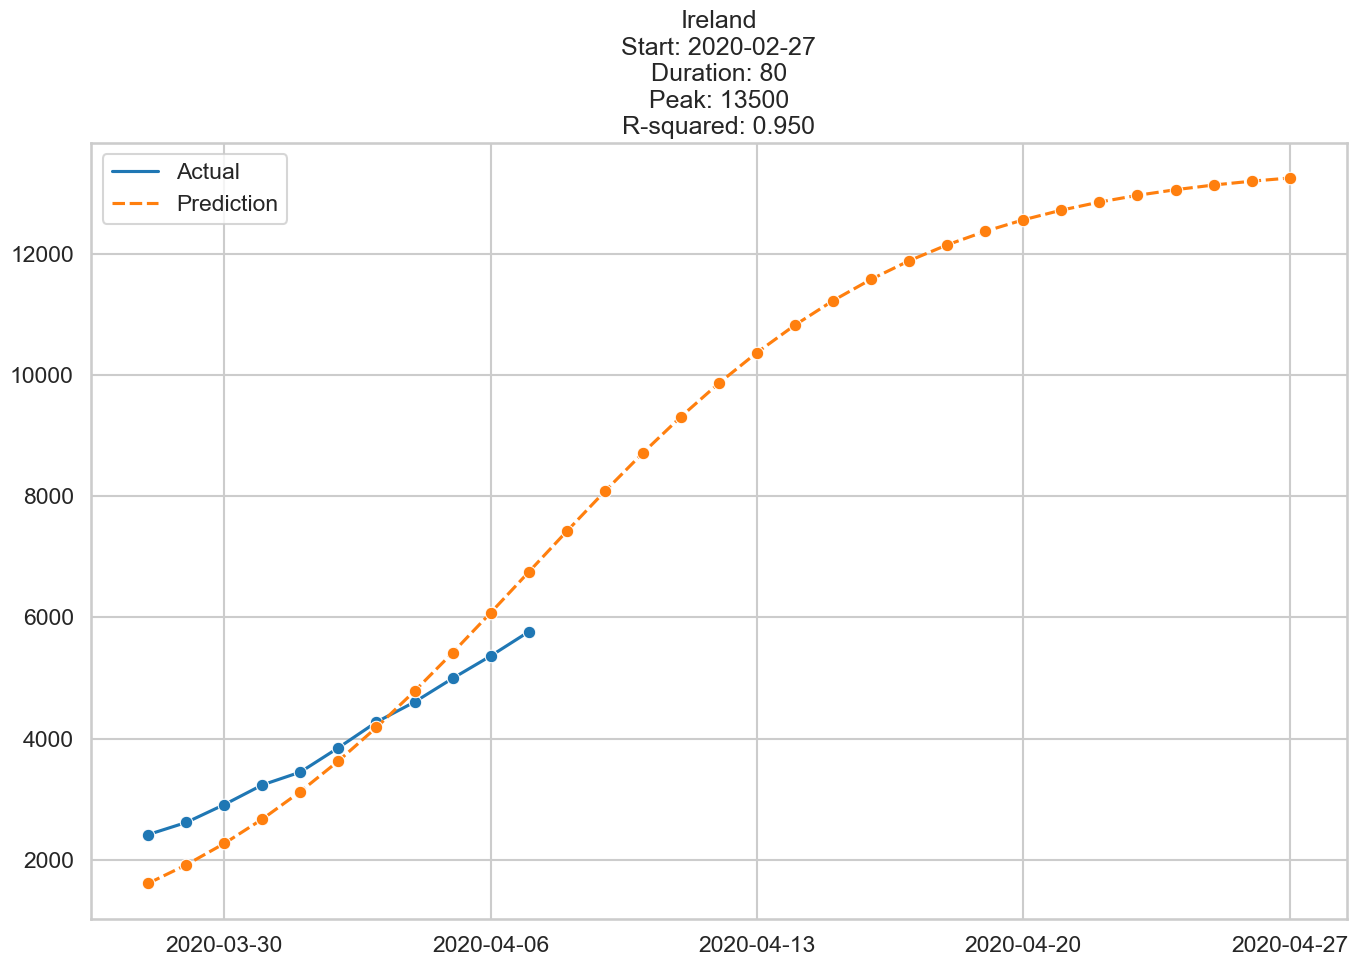

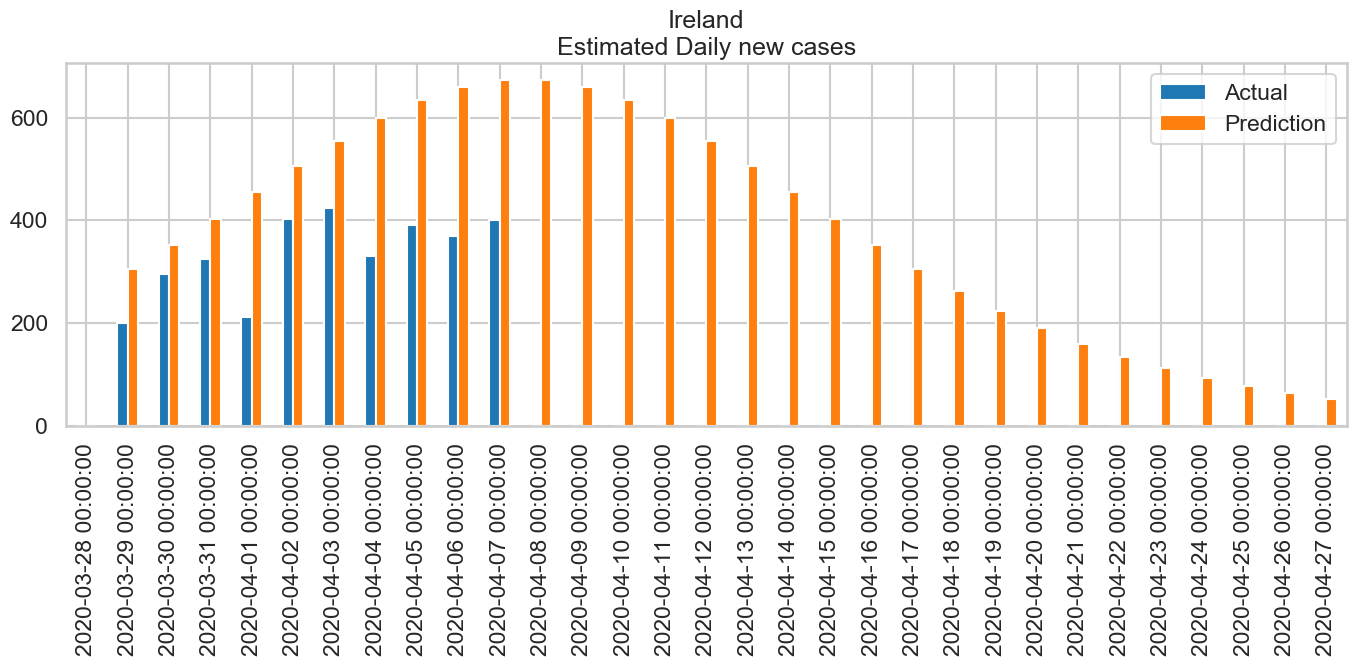

In [515]:
country = 'Ireland'
start_str = '2020-02-27'
peak_guess = 20000
duration_guess = 7*12

tidy_df = add_today(tidy_df, country, 5764)

ei_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess)

## Romania

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


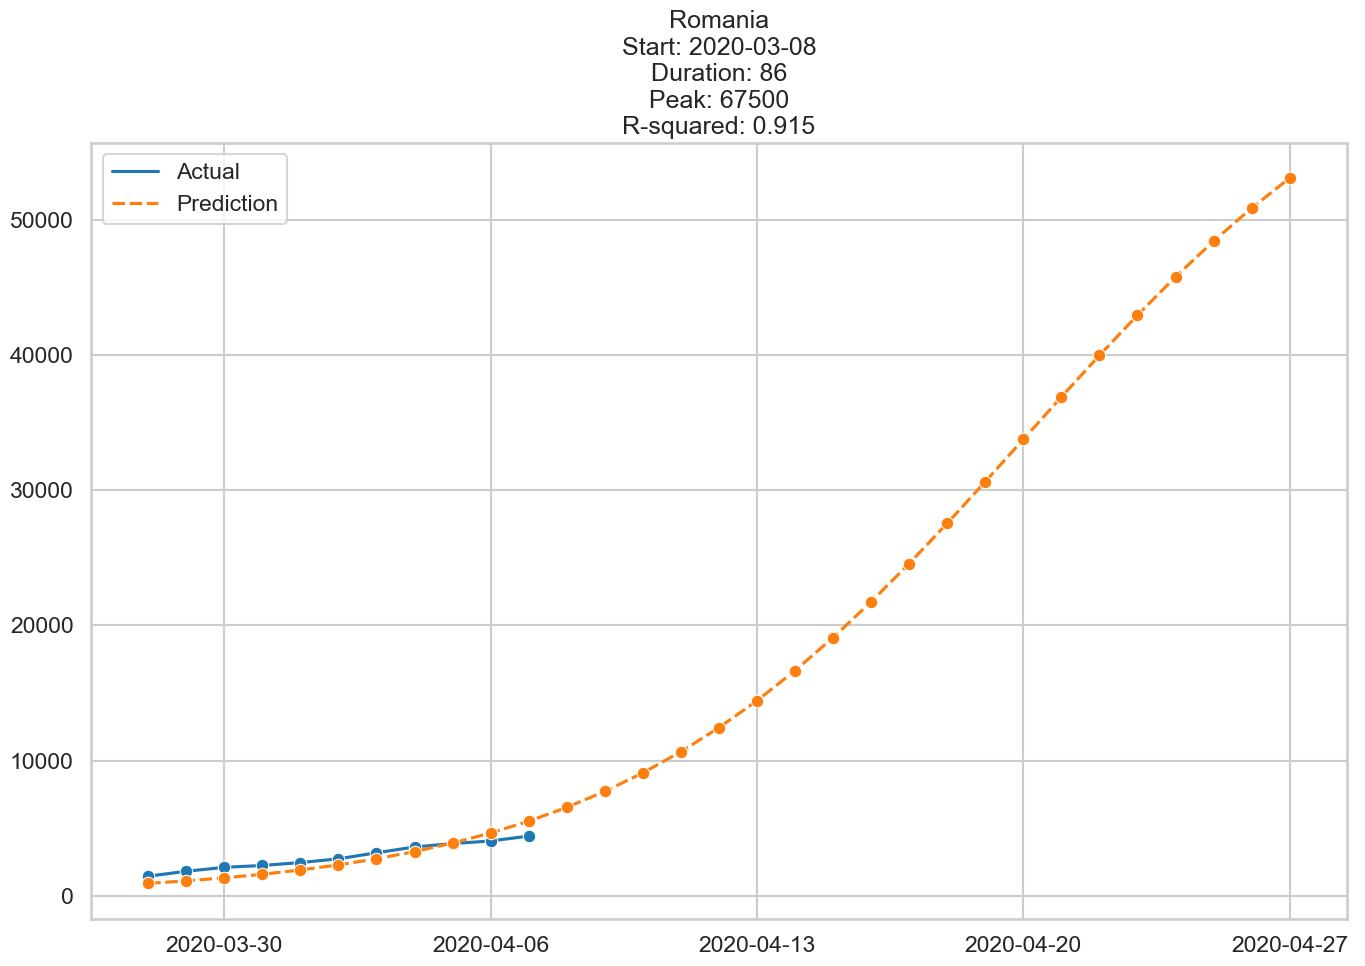

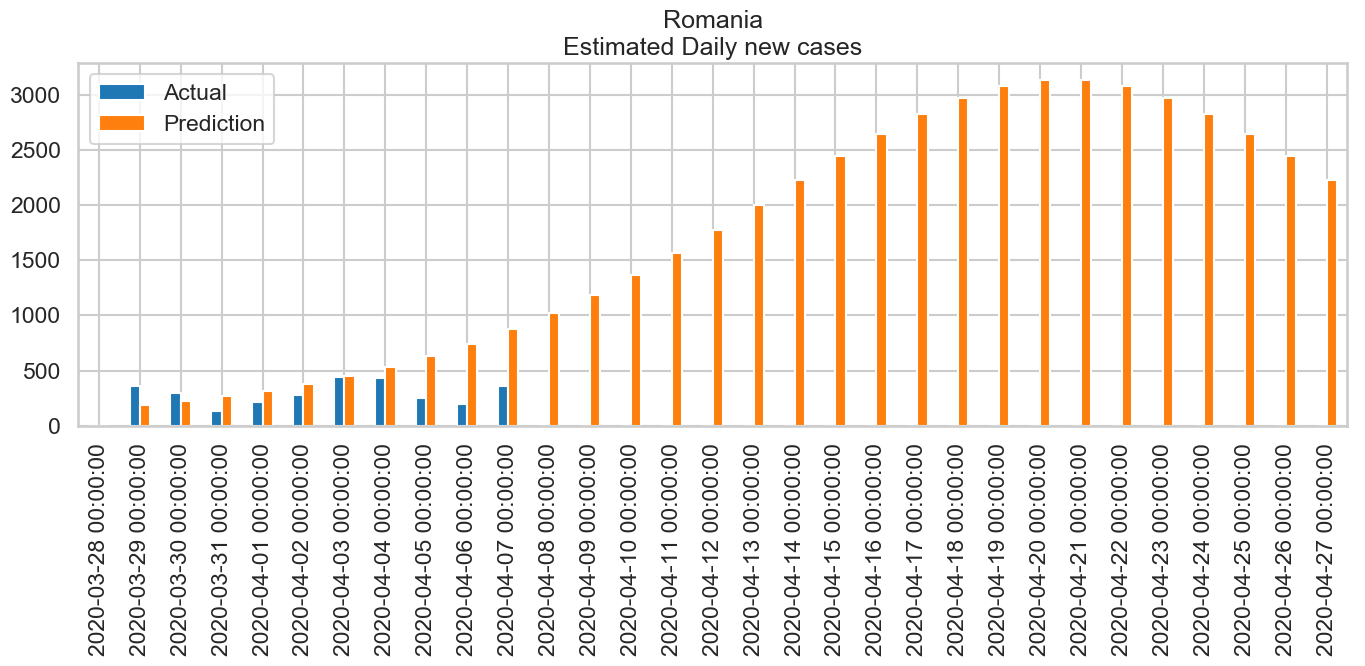

In [537]:
country = 'Romania'
start_str = '2020-03-08'
peak_guess = 50000
duration_guess = 7*12

tidy_df = add_today(tidy_df, country, 4417)

ei_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     strategy='rmse',
                     #offset=5
                    )

## France
31st March - France appear close to their peak. The next 4 days should help calibrate that.

### 5th April
From 4th April, John Hopkins data is diverges from the official French. There is a good reason for that (counting care home deaths, rather than just hospital deaths), but I will use the official source for now. This is here:
* https://www.santepubliquefrance.fr/maladies-et-traumatismes/maladies-et-infections-respiratoires/infection-a-coronavirus/articles/infection-au-nouveau-coronavirus-sars-cov-2-covid-19-france-et-monde
The values vary much more than any country. It is quite strange. However, the actual points snake closely to prediction, much like a creeping plant climbing a wire.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


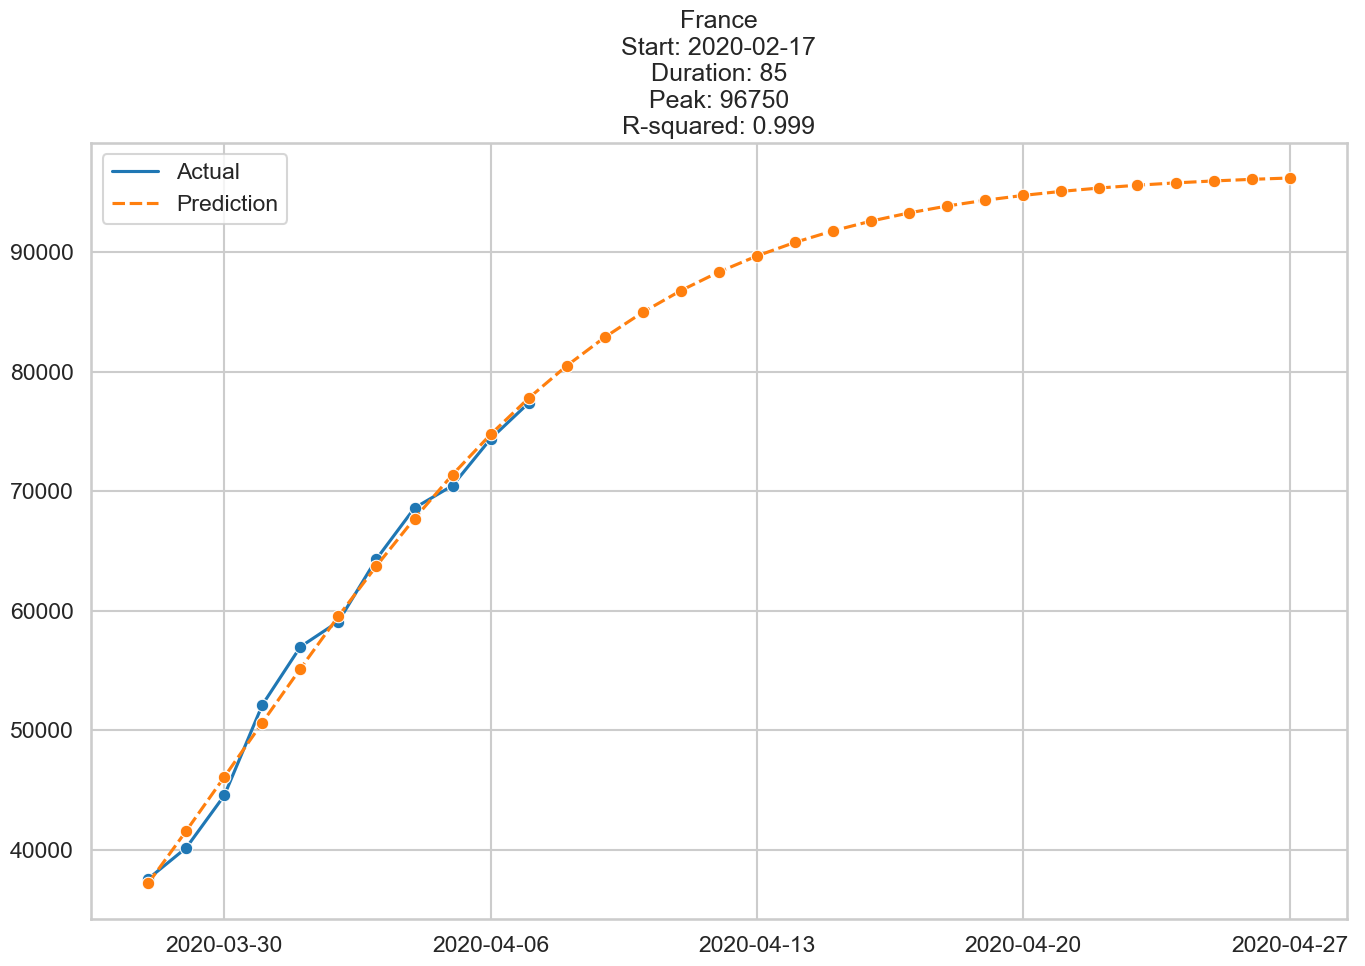

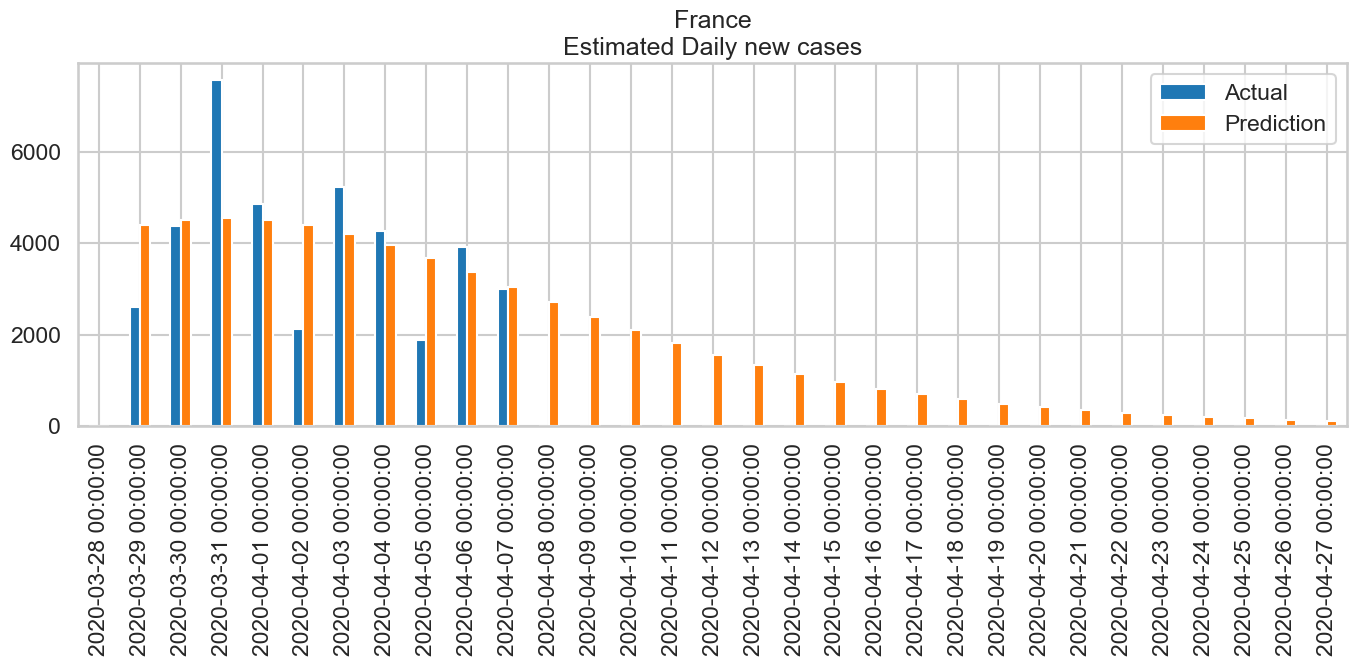

In [517]:
country = 'France'
province = True
start_str = '2020-02-17'
peak_guess = 90000
duration_guess = 7*12

# fix data errors
corrections = {'2020-03-12': 2876,
               '2020-03-15': 5423,
               '2020-03-30': 44550,
               '2020-03-31': 52128,
               '2020-04-01': 56989,
               '2020-04-04': 68605,
               '2020-04-05': 70478,
               '2020-04-06': 74390,
              }

for date, value in corrections.items():
    idx = tidy_df['Country/Region'] == country
    idx &= tidy_df['Province/State'] == country
    idx &= tidy_df.index == pd.to_datetime(date)
    tidy_df.loc[idx, 'Cases'] = value

tidy_df = add_today(tidy_df, country, 77390, province=province)

fr_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     strategy='rmse',
                     spread=16,
                     province=province)

## Denmark

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


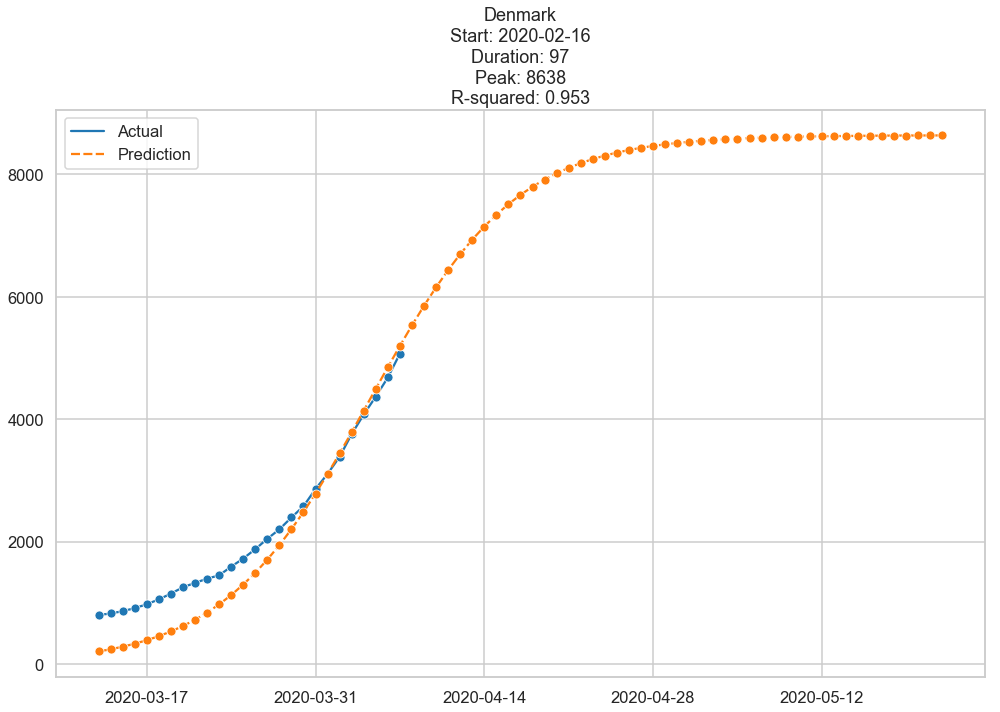

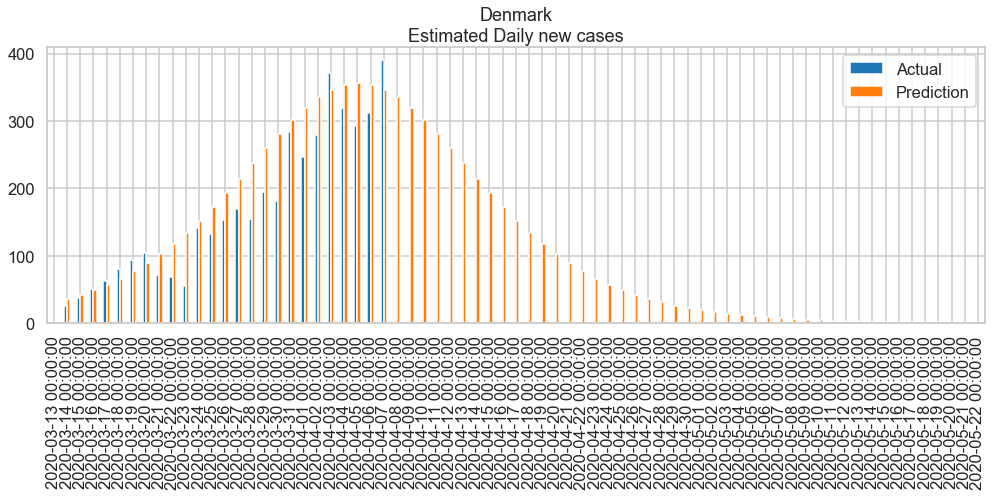

In [26]:
country = 'Denmark'
province = True
start_str = '2020-02-16'
peak_guess = 7500
duration_guess = (7*14)+3

tidy_df = add_today(tidy_df, 'Denmark', 5071, province=province)

dk_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     offset=duration_guess/4,
                     strategy='best_fit_last',
                     province=province,
                    )

## Australia

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:33: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


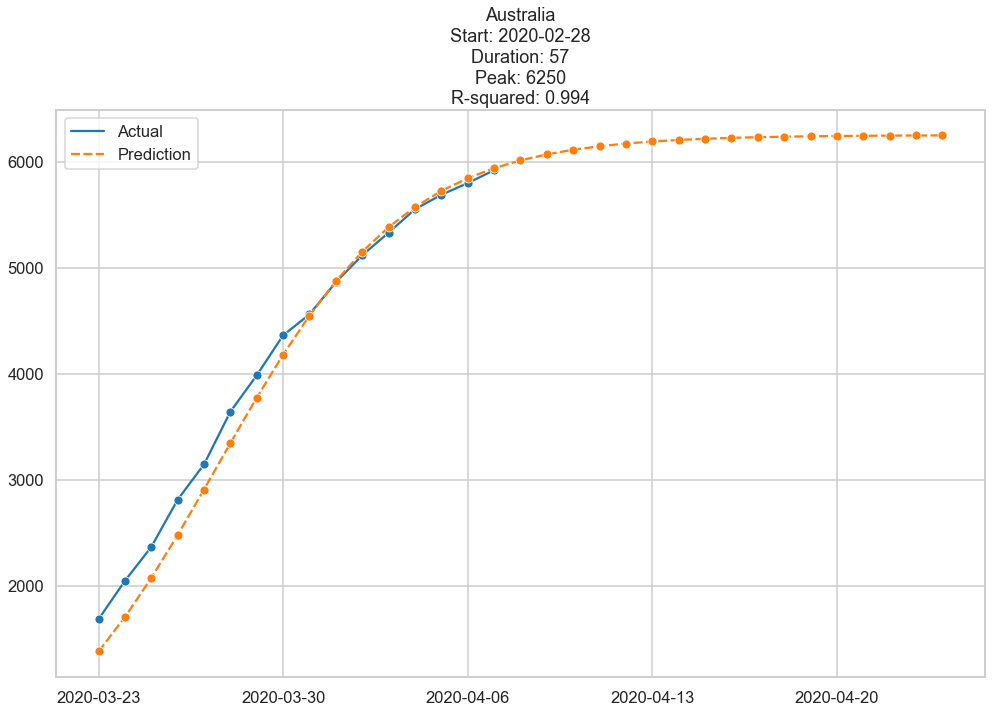

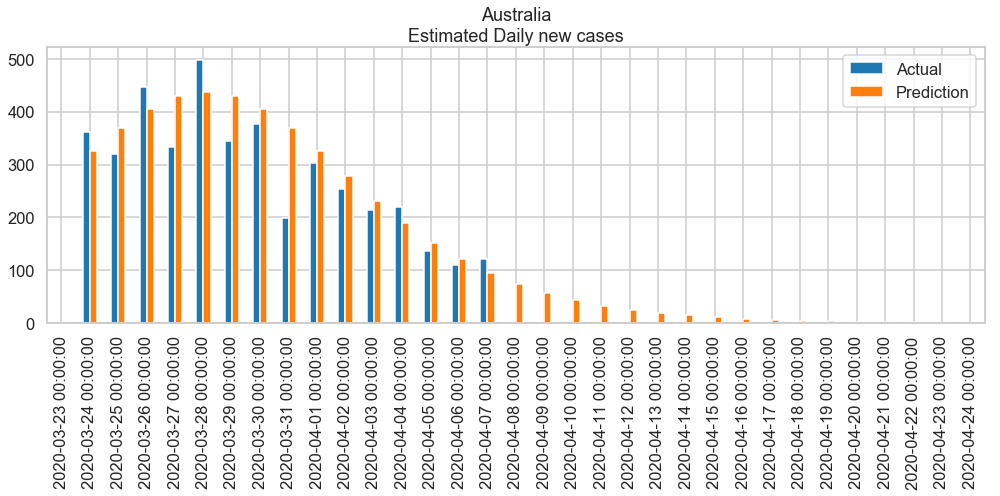

In [27]:
country = 'Australia'
province = True
start_str = '2020-02-28'
peak_guess = 10000
duration_guess = 7*9-2

tidy_df = add_today(tidy_df, 'New South Wales', 5919, province=True)

au_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     offset=duration_guess/4,
                    )

## Sweden
Sweden is interesting - it's made up of distinct S-curves. So fitting just one, isn't working well. Singapore was similar. It will be interesting to know why - Sweden are surpressing, not containing the outbreak. Which is very different to Singapore. Granted Sweden is much less dense - but people still live in relatively large cities.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:74: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


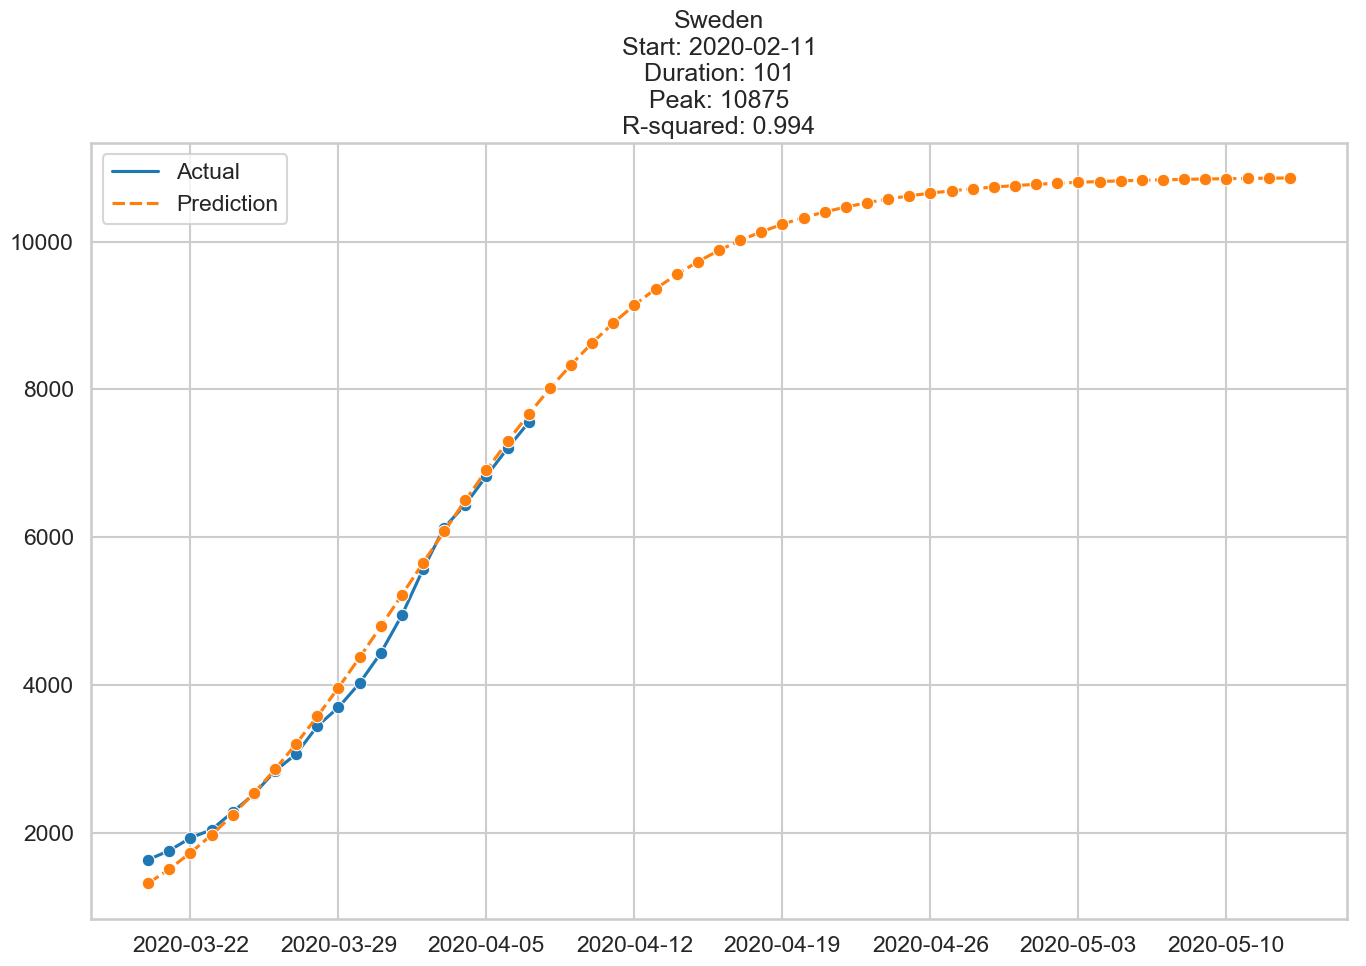

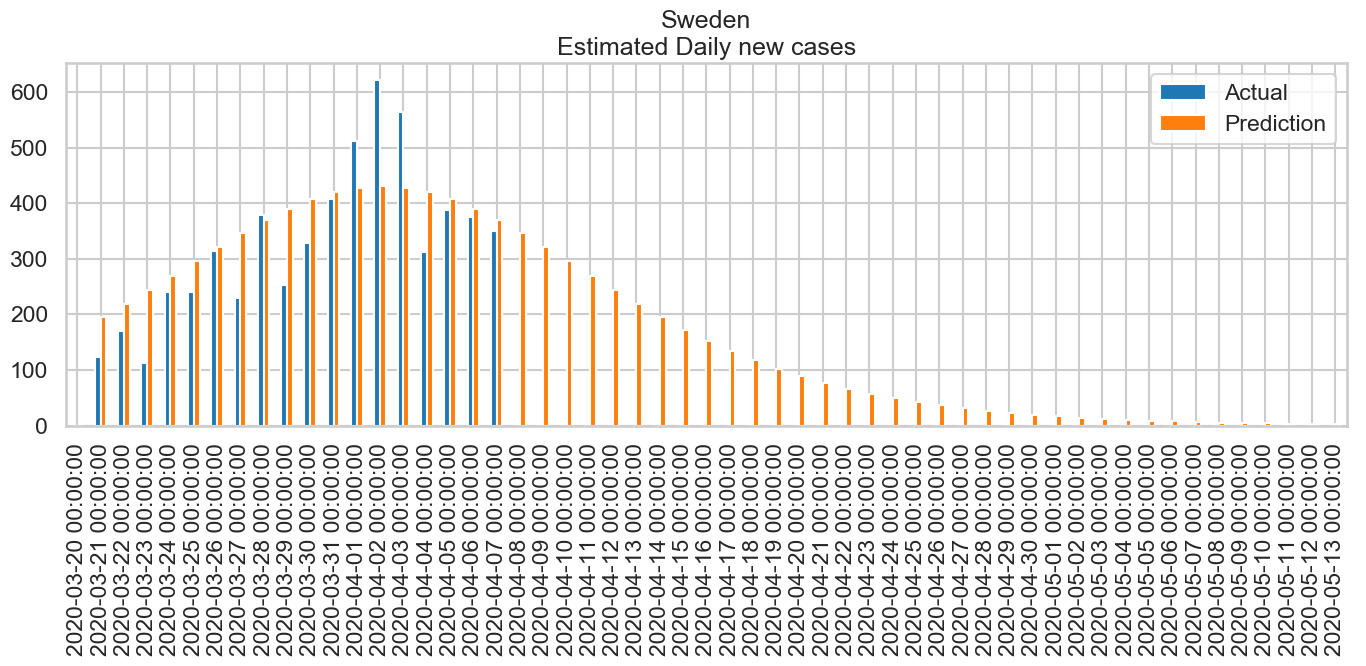

In [522]:
country = 'Sweden'
#start_str = '2020-02-25'
start_str = '2020-02-11'
peak_guess = 15000
duration_guess = 7*15

tidy_df = add_today(tidy_df, country, 7556)

se_df = plot_country(tidy_df,
                     country=country,
                     start_str=start_str,
                     peak_guess=peak_guess,
                     duration_guess=duration_guess,
                     spread=16,
                     offset=round(duration_guess/6),
                    )

## Comparison
Compare each country at the same point in the virus spread, per 1M population. Granted, for very big continents this dilutes the figures significantly, but it also reflects that it is easier on a continent with large population separation to reduce total population spread with lock downs. In more dense countries with very little separation (India), it is march harder to reduce transmission because little journeys don't stick out as much as long journeys.

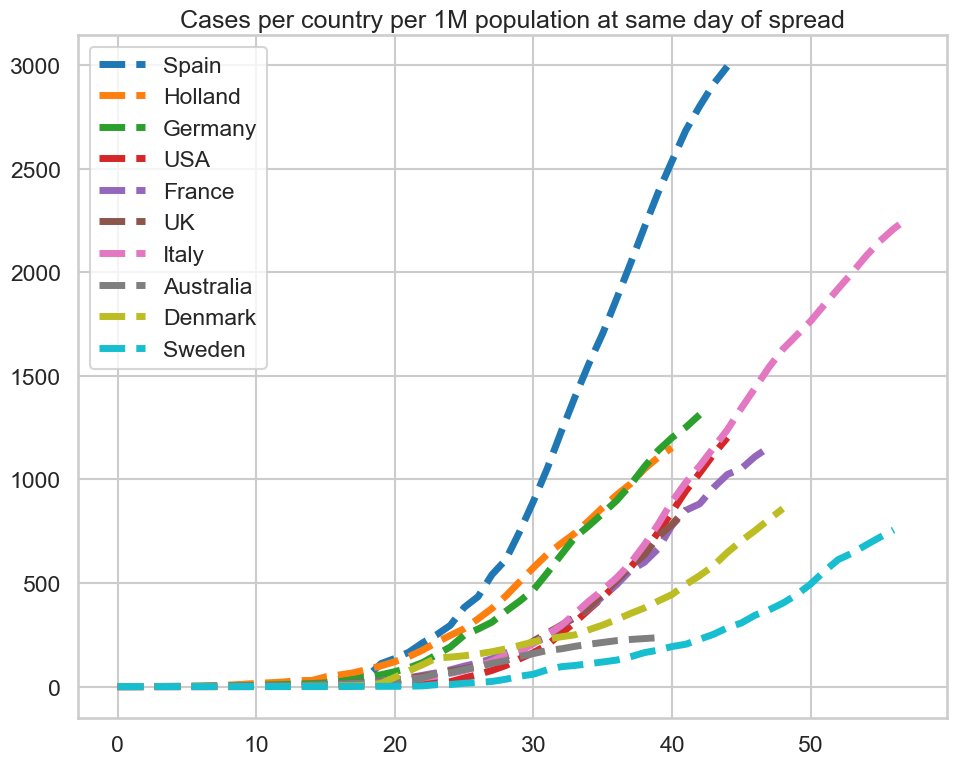

In [523]:
cty_dict={
#    'China': cn_df.loc['2020-01-04':, 'Actual'].dropna().values/47,
    'Spain': es_df.loc['2020-02-23':, 'Actual'].dropna().values/47,
    'Holland': nd_df.loc['2020-02-27':, 'Actual'].dropna().values/17,
    'Germany': de_df.loc['2020-02-24':, 'Actual'].dropna().values/80,
    'USA': us_df.loc['2020-02-23':, 'Actual'].dropna().values/327,
    'France': fr_df.loc['2020-02-20':, 'Actual'].dropna().values/67,
    'UK': gb_df.loc['2020-02-26':, 'Actual'].dropna().values/66,
    'Italy': it_df.loc['2020-02-10':, 'Actual'].dropna().values/60,
    'Denmark': dk_df.loc['2020-02-19':, 'Actual'].dropna().values/5.8,
    'Sweden': se_df.loc['2020-02-05':, 'Actual'].dropna().values/10,
    'Australia': au_df.loc['2020-02-27':, 'Actual'].dropna().values/25,
         }

length = 0
for country, df in cty_dict.items():
    length = max(len(df), length)

empty = [np.nan] * length
temp_df = pd.DataFrame({
#    'China': empty,
    'Spain': empty,
    'Holland': empty,
    'Germany': empty,
    'USA': empty,
    'France': empty,
    'UK': empty,
    'Italy': empty,
    'Australia': empty,
    'Denmark': empty,
    'Sweden': empty,
})
  
for col, vals in cty_dict.items():
    length = len(vals)
    col_pos = temp_df.columns.values.tolist().index(col)
    temp_df.iloc[:length, col_pos] = vals

temp_df.plot(linestyle='--', linewidth=5, figsize=(10,8))
plt.title('Cases per country per 1M population at same day of spread')
#plt.yscale('log')
plt.tight_layout()
plt.show()

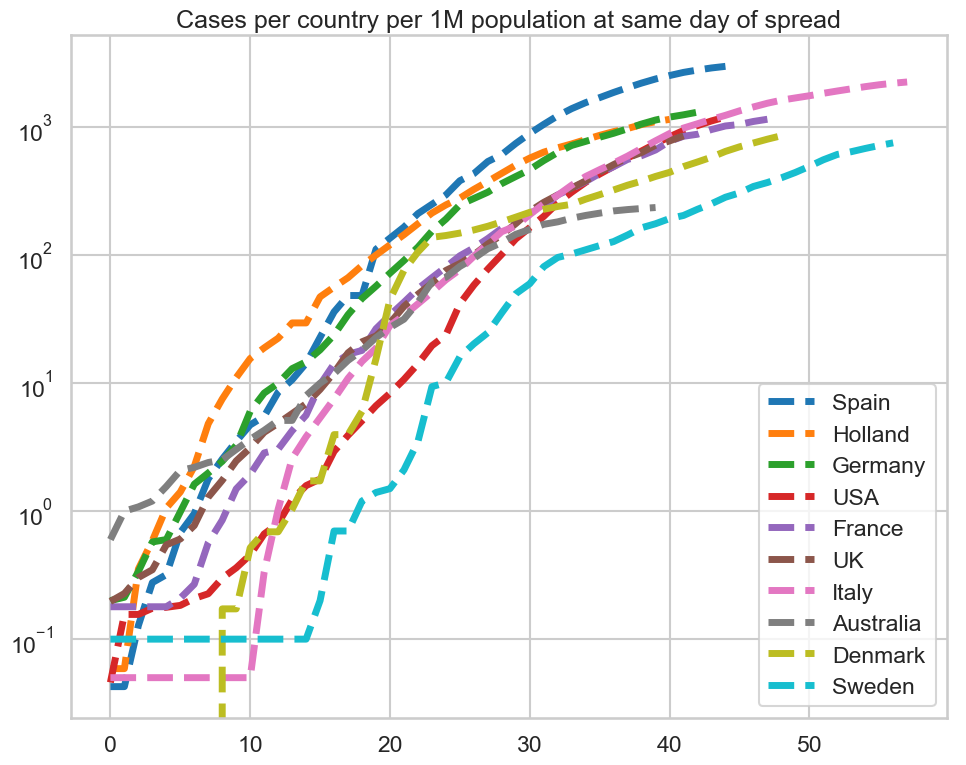

In [524]:
temp_df.plot(linestyle='--', linewidth=5, figsize=(10,8))
plt.title('Cases per country per 1M population at same day of spread')
plt.yscale('log')
plt.tight_layout()
plt.show()

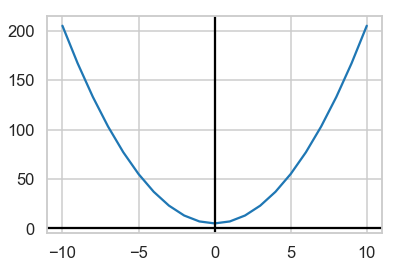

In [179]:
def poly(x, coeff):
    """ Return y for the polynomial equation defined with 
        the co-efficients provided - in order of highest power.
        i.e. just as you would write the equation in a text book, 
        rather than a Taylor series."""
    order = len(coeff)
    y = 0
    for power in range(order):
        idx = order - power - 1
        y += coeff[idx] * (x**power)
    return y

coeff = (2, 0, 5)
x = list(range(-10,11))
y = [poly(x, coeff) for x in x]

plt.plot(x,y)
plt.axhline(0, c='black')
plt.axvline(0, c='black')
plt.show()